In [1]:
import pandas as pd
import glob
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm.auto import tqdm

C:\Users\javedm\AppData\Local\Temp\ipykernel_10952\1233876273.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\javedm\AppData\Local\miniconda3\envs\snakemake\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_pop = pd.read_csv("data/statistics/population_2021.tsv",sep="\t").set_index('country').rename({'GB' : 'UK'}).sort_index()
df_pop

,population,source
country,,
AT,8932664,https://ec.europa.eu/eurostat/databrowser/view...
BE,11554767,https://ec.europa.eu/eurostat/databrowser/view...
BG,6916548,https://ec.europa.eu/eurostat/databrowser/view...
CH,8670300,https://ec.europa.eu/eurostat/databrowser/view...
CY,896007,https://ec.europa.eu/eurostat/databrowser/view...
CZ,10701777,https://ec.europa.eu/eurostat/databrowser/view...
DE,83155031,https://ec.europa.eu/eurostat/databrowser/view...
DK,5840045,https://ec.europa.eu/eurostat/databrowser/view...
EE,1330068,https://ec.europa.eu/eurostat/databrowser/view...


In [3]:
df_econ = pd.read_csv("data/economic_indic.tsv", sep="\t").set_index("country").rename({'GB':'UK'}).sort_index()
df_land = pd.read_csv("data/statistics/land_area_wb.tsv", sep="\t").set_index("country").rename({'GB':'UK'})
df_emissions = pd.read_csv('data/emissions_1900_2021.tsv',sep='\t').drop(columns={'Unnamed: 0'}).set_index('Code').rename(columns={'0' : 'emissions_1900_2021'})


In [4]:
clusterpath = "C:/Users/javedm/MENOFS/EU10CS/"

In [5]:
#Converting into .db file
#gamspath = "C:/GAMS/"
#resultspath = "C:/Users/javedm/MENOFS/EU10CS/results/"
#!{gamspath}gdx2sqlite -i {resultspath + "SE_Solar_maximizing_0.07/results.gdx"} -o {resultspath + "SE_Solar_maximizing_0.07/results.db"} -fast

In [6]:
#Looking into all .db files in the results directory
scenarios = glob.glob(clusterpath + "results/**/*.db", recursive=True)
scenarios

['C:/Users/javedm/MENOFS/EU10CS/results\\NO_Solar_maximizing_0.07\\results.db',
 'C:/Users/javedm/MENOFS/EU10CS/results\\SE_Solar_maximizing_0.07\\results.db']

In [7]:
for i in range(len(scenarios)):
    scenarios[i] = scenarios[i].replace('results\\','')
    scenarios[i] = scenarios[i].replace('C:/Users/javedm/MENOFS/EU10CS/','')
    scenarios[i] = scenarios[i].replace('.db','')
    scenarios[i] = scenarios[i].replace('\\results','')
    #scenarios[i] = scenarios[i].replace('\\','/')

In [8]:
scenarios

['NO_Solar_maximizing_0.07', 'SE_Solar_maximizing_0.07']

In [9]:
scenarios_short = scenarios

In [10]:
#Total system cost
costs = []
for scenario in tqdm(scenarios_short):
    con = sqlite3.connect(clusterpath + "results/" + str(scenario) + "/results.db")
    costs.append(
        pd
        .read_sql_query("SELECT * from scalarvariables", con)
        .set_index('name')
        .stack()
        .reset_index()
        .rename(columns={'name' : 'variable'})
        .assign(scenario = scenario)
        .set_index(['scenario','variable','level_1'])
        .loc[(slice(None), slice(None), 'level')]
        .sort_index()
    )
    con.close()
df_costs = pd.concat(costs)
del(costs)
df_costs

100%|██████████| 2/2 [00:00<00:00, 49.94it/s]


0
scenario                 variable                       
NO_Solar_maximizing_0.07 objective           1118.942574
                         var_system_costs  329954.830001
SE_Solar_maximizing_0.07 objective           1148.277304
                         var_system_costs  329954.830000

In [11]:
df_costs.loc[(slice(None),'var_system_costs',slice(None))]

,0
scenario,
NO_Solar_maximizing_0.07,329954.830001
SE_Solar_maximizing_0.07,329954.830000


In [12]:
dem = pd.DataFrame()

for scenario in tqdm(scenarios_short):
    con = sqlite3.connect(clusterpath + "results/" + str(scenario) + "/results.db")
    temp = pd.read_sql_query(
        "SELECT * from demand", 
        con
    ).rename(
        columns={
            "z": "zone",
            "h": "hour",
            'value' : 'demand_GWh'
        }
    ).groupby('zone').sum()#.unstack().reset_index()
    temp['scenario'] = scenario
    frames = [dem, temp]
    dem = pd.concat(frames)

dem = dem.reset_index().set_index(['scenario','zone'])
dem

100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


hour  \
scenario                 zone                                                      
NO_Solar_maximizing_0.07 AT    0123456789101112131415161718192021222324252627...   
                         BE    0123456789101112131415161718192021222324252627...   
                         BG    0123456789101112131415161718192021222324252627...   
                         CH    0123456789101112131415161718192021222324252627...   
                         CZ    0123456789101112131415161718192021222324252627...   
                         DE    0123456789101112131415161718192021222324252627...   
                         DK    0123456789101112131415161718192021222324252627...   
                         EE    0123456789101112131415161718192021222324252627...   
                         ES    0123456789101112131415161718192021222324252627...   
                         FI    0123456789101112131415161718192021222324252627...   
                         FR    0123456789101112131415161718192021222324252627...   
                         GR    0123456789101112131415161718192021222324252627...   
                         HR    0123456789101112131415161718192021222324252627...   
                         HU    0123456789101112131415161718192021222324252627...   
                         IE    0123456789101112131415161718192021222324252627...   
                         IT    0123456789101112131415161718192021222324252627...   
                         LT    0123456789101112131415161718192021222324252627...   
                         LU    0123456789101112131415161718192021222324252627...   
                         LV    0123456789101112131415161718192021222324252627...   
                         NL    0123456789101112131415161718192021222324252627...   
                         NO    0123456789101112131415161718192021222324252627...   
                         PL    0123456789101112131415161718192021222324252627...   
                         PT    0123456789101112131415161718192021222324252627...   
                         RO    0123456789101112131415161718192021222324252627...   
                         SE    0123456789101112131415161718192021222324252627...   
                         SI    0123456789101112131415161718192021222324252627...   
                         SK    0123456789101112131415161718192021222324252627...   
                         UK    0123456789101112131415161718192021222324252627...   
SE_Solar_maximizing_0.07 AT    0123456789101112131415161718192021222324252627...   
                         BE    0123456789101112131415161718192021222324252627...   
                         BG    0123456789101112131415161718192021222324252627...   
                         CH    0123456789101112131415161718192021222324252627...   
                         CZ    0123456789101112131415161718192021222324252627...   
                         DE    0123456789101112131415161718192021222324252627...   
                         DK    0123456789101112131415161718192021222324252627...   
                         EE    0123456789101112131415161718192021222324252627...   
                         ES    0123456789101112131415161718192021222324252627...   
                         FI    0123456789101112131415161718192021222324252627...   
                         FR    0123456789101112131415161718192021222324252627...   
                         GR    0123456789101112131415161718192021222324252627...   
                         HR    0123456789101112131415161718192021222324252627...   
                         HU    0123456789101112131415161718192021222324252627...   
                         IE    0123456789101112131415161718192021222324252627...   
                         IT    0123456789101112131415161718192021222324252627...   
                         LT    0123456789101112131415161718192021222324252627...   
                         LU    0123456789101112131415161718192021222324252627...   
                         LV    0123456789101

In [13]:
gen = []

how = 'quick'

if how == 'quick':
    for scenario in tqdm(scenarios_short):
        con = sqlite3.connect(clusterpath + "results/" + str(scenario) + "/results.db")
        gen.append(
            pd
            .read_sql_query("SELECT * from var_gen", con)
            .drop(columns={'lo','up','marginal'})   #It is optional
            .set_index(['z','h','g'])
            .stack()
            .reset_index()
            .rename(columns={
                        "z": "zone",
                        "g": "technology",
                        "h": "hour",
                        "level_3" : "type",
                        0: 'electricity_generatioN_GWh'
                    })
            .assign(scenario=scenario)
            .astype({'hour' : int})
            .set_index(['scenario','zone','technology','hour','type'])
            .sort_index()
            )
        con.close()
    df_gen = pd.concat(gen)
    del(gen)
    df_gen
    

100%|██████████| 2/2 [00:17<00:00,  8.58s/it]


In [14]:
df_gen

electricity_generatioN_GWh
scenario                 zone technology  hour type                             
NO_Solar_maximizing_0.07 AT   HydroRes    0    level                7.257657e-09
                                          1    level                7.257638e-09
                                          2    level                7.257672e-09
                                          3    level                7.257705e-09
                                          4    level                7.257710e-09
...                                                                          ...
SE_Solar_maximizing_0.07 UK   Windonshore 8755 level                4.138963e+00
                                          8756 level                4.336057e+00
                                          8757 level                4.336057e+00
                                          8758 level                4.533150e+00
                                          8759 level                4.533150e+00

[3784320 rows x 1 columns]

In [15]:
gen = (df_gen
       .loc[slice(None),slice(None),slice(None),slice(None),'level']
       .groupby(['scenario','zone'])
       .sum()
       .reset_index()
       .set_index(['scenario','zone'])
           .rename(columns={'electricity_generatioN_GWh' : 'generation_GWh'})
    .assign(
        demand = dem.demand_GWh,
        self_suf = lambda x : x.generation_GWh/x.demand,
       )
)

gen

generation_GWh        demand  self_suf
scenario                 zone                                        
NO_Solar_maximizing_0.07 AT      1.927944e+05  1.274303e+05  1.512940
                         BE      9.687082e+04  1.739532e+05  0.556879
                         BG      7.332881e+04  7.497775e+04  0.978008
                         CH      1.287698e+05  1.261205e+05  1.021006
                         CZ      9.229502e+04  1.310577e+05  0.704232
                         DE      1.004850e+06  1.034011e+06  0.971798
                         DK      5.891363e+04  6.908834e+04  0.852729
                         EE      1.165455e+04  1.691337e+04  0.689074
                         ES      5.154384e+05  5.093293e+05  1.011994
                         FI      1.583361e+05  1.744350e+05  0.907708
                         FR      1.220936e+06  9.966687e+05  1.225017
                         GR      1.021777e+05  1.015920e+05  1.005765
                         HR      5.020949e+04  3.488745e+04  1.439185
                         HU      6.001349e+04  8.740748e+04  0.686594
                         IE      7.797024e+04  5.557413e+04  1.402995
                         IT      6.451153e+05  6.203218e+05  1.039969
                         LT      2.638511e+04  2.261750e+04  1.166580
                         LU      4.552684e+03  1.313292e+04  0.346662
                         LV      1.331923e+04  1.460747e+04  0.911810
                         NL      2.098506e+05  2.246988e+05  0.933920
                         NO      4.065080e+05  2.200000e+05  1.847764
                         PL      3.251290e+05  3.418311e+05  0.951139
                         PT      6.880671e+04  9.922652e+04  0.693431
                         RO      1.367000e+05  1.104364e+05  1.237817
                         SE      2.406636e+05  2.760000e+05  0.871970
                         SI      6.131518e+03  2.758979e+04  0.222239
                         SK      3.852707e+04  5.743619e+04  0.670780
                         UK      6.253297e+05  6.554755e+05  0.954009
SE_Solar_maximizing_0.07 AT      1.934383e+05  1.274303e+05  1.517993
                         BE      1.058532e+05  1.739532e+05  0.608516
                         BG      7.198473e+04  7.497775e+04  0.960081
                         CH      1.246745e+05  1.261205e+05  0.988534
                         CZ      8.839915e+04  1.310577e+05  0.674505
                         DE      1.001145e+06  1.034011e+06  0.968215
                         DK      6.236965e+04  6.908834e+04  0.902752
                         EE      1.083408e+04  1.691337e+04  0.640563
                         ES      5.166959e+05  5.093293e+05  1.014463
                         FI      1.456101e+05  1.744350e+05  0.834753
                         FR      1.233835e+06  9.966687e+05  1.237959
                         GR      1.041155e+05  1.015920e+05  1.024839
                         HR      4.947759e+04  3.488745e+04  1.418206
                         HU      6.157442e+04  8.740748e+04  0.704453
                         IE      8.001955e+04  5.557413e+04  1.439871
                         IT      6.499948e+05  6.203218e+05  1.047835
                         LT      2.917736e+04  2.261750e+04  1.290035
                         LU      4.605602e+03  1.313292e+04  0.350691
                         LV      1.125704e+04  1.460747e+04  0.770636
                         NL      2.083601e+05  2.246988e+05  0.927286
                         NO      1.956188e+05  2.200000e+05  0.889176
                         PL      3.264216e+05  3.418311e+05  0.954921
                         PT      6.714145e+04  9.922652e+04  0.676648
                         RO      1.371218e+05  1.104364e+05  1.241636
                         SE      4.093924e+05  2.760000e+05  1.483306
                         SI      6.685459e+03  2.758979e+04  0.242316
                         SK      3.751952e+04  5.743619e+04  0.653238
                         UK      6.541323

In [16]:
#Gini coefficients
#Self_sufficiency: Countries should generate what they consume (Gen per dem)
df_score = pd.DataFrame(columns=['scenario','principle','zone','score'])
df_score

,scenario,principle,zone,score


In [17]:
df_gini = pd.DataFrame(columns=['scenario','gini_c','principle' ])

for scenario in tqdm(gen.reset_index().scenario.unique()):
    temp = gen.loc[scenario, slice(None)].assign(
        share_gen = lambda x : x.generation_GWh/x.generation_GWh.sum(),
        share_dem = lambda x : x.demand/x.demand.sum()
    ).sort_values(
        'self_suf',
        ascending = True
    ).assign(
        cumulative_gen = lambda x: x.share_gen.cumsum(),
        cumulative_dem = lambda x: x.share_dem.cumsum(),
        score = lambda x: x.share_gen * (x.share_dem + 2*(1-x.cumulative_dem))        
    )
    gini = 1-temp.score.sum()
    df_gini = pd.concat([df_gini, pd.DataFrame({'scenario': scenario, 'gini_c': gini, 'principle': 'genperdem'}, index=[0])])
    
    new_score = temp.reset_index().loc[
        :, ["zone", "self_suf"]
    ].assign(
        scenario = scenario,
        score = lambda x : x.self_suf/x.self_suf.sum(),
        principle = 'genperdem'        
    ).drop(
        columns={'self_suf'}
    )
    frames = [df_score, new_score]
    df_score = pd.concat(frames)            #Each time run, repeatedly add the same rows, be careful

df_score

100%|██████████| 2/2 [00:00<00:00, 62.50it/s]


,scenario,principle,zone,score
0,NO_Solar_maximizing_0.07,genperdem,SI,0.008288
1,NO_Solar_maximizing_0.07,genperdem,LU,0.012928
2,NO_Solar_maximizing_0.07,genperdem,BE,0.020768
3,NO_Solar_maximizing_0.07,genperdem,SK,0.025016
4,NO_Solar_maximizing_0.07,genperdem,HU,0.025606
5,NO_Solar_maximizing_0.07,genperdem,EE,0.025698
6,NO_Solar_maximizing_0.07,genperdem,PT,0.025861
7,NO_Solar_maximizing_0.07,genperdem,CZ,0.026264
8,NO_Solar_maximizing_0.07,genperdem,DK,0.031802
9,NO_Solar_maximizing_0.07,genperdem,SE,0.032519


In [18]:
df_gini

,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
0,SE_Solar_maximizing_0.07,0.105923,genperdem


In [19]:
#To which scenario these values belong to? There were 709 scenarios right?
temp_gen_dem = temp.copy(
).sort_values(
    'self_suf',
    ascending=True
)
temp_gen_dem

,generation_GWh,demand,self_suf,share_gen,share_dem,cumulative_gen,cumulative_dem,score
zone,,,,,,,,
SI,6.685459e+03,2.758979e+04,0.242316,0.001015,0.004313,0.001015,0.004313,0.002025
LU,4.605602e+03,1.313292e+04,0.350691,0.000699,0.002053,0.001714,0.006366,0.001391
BE,1.058532e+05,1.739532e+05,0.608516,0.016069,0.027194,0.017783,0.033560,0.031496
EE,1.083408e+04,1.691337e+04,0.640563,0.001645,0.002644,0.019428,0.036204,0.003175
SK,3.751952e+04,5.743619e+04,0.653238,0.005696,0.008979,0.025123,0.045183,0.010928
CZ,8.839915e+04,1.310577e+05,0.674505,0.013419,0.020488,0.038543,0.065671,0.025351
PT,6.714145e+04,9.922652e+04,0.676648,0.010192,0.015512,0.048735,0.081182,0.018888
HU,6.157442e+04,8.740748e+04,0.704453,0.009347,0.013664,0.058082,0.094847,0.017049
LV,1.125704e+04,1.460747e+04,0.770636,0.001709,0.002284,0.059791,0.097130,0.003090


Text(0.5, 0.55, 'Line of perfect equality')

<Figure size 800x800 with 0 Axes>

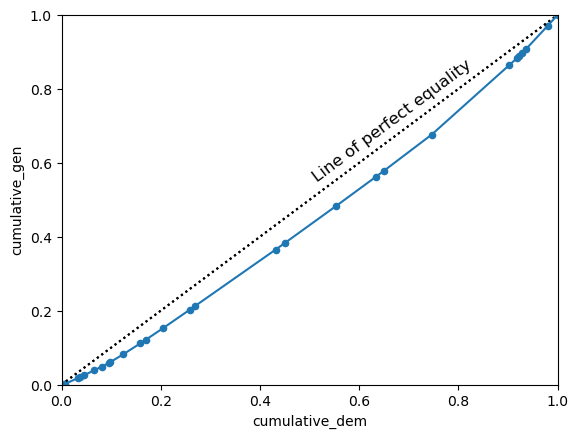

In [20]:
import numpy as np
from scipy import integrate
from scipy.interpolate import interp1d

# create the df for the linear plot
df1 = pd.DataFrame({
   'x': [0,1],
   'y': [0,1]
   }
)

plt.figure(figsize=(8,8))
ax = df1.plot(
    legend = None,
    linestyle = ':',
    color = 'k'
)

temp_gen_dem.plot.scatter(
    x = 'cumulative_dem',
    y = 'cumulative_gen',
    xlim = [0,1],
    ylim = [0,1],
    ax=ax
)

x = temp_gen_dem.cumulative_dem.to_numpy(copy=True)
x = np.insert(x,0,0)
y = temp_gen_dem.cumulative_gen.to_numpy(copy=True)
y = np.insert(y,0,0)
f = interp1d(x, y)          #generated the piecewise interpolation function

B = integrate.quad(f,0,1, epsabs = 1e-4)            #Integarting the piecewise funtion from 0 to 1
G = 1-2*B[0]

plt.plot(x,y)

plt.text(
    df1.x.mean(),
    df1.y.mean()+0.05, 
    'Line of perfect equality',
    rotation = 45,
    #rotation=math.degrees(math.atan(a/b)), 
    #ha = 'center',
    transform_rotates_text=True,
    size = 12
)

In [21]:
#capability: countries should generate based on their capability (cap per PPP GDP)
p_cap_dfs = []
for scenario in tqdm(scenarios_short):
    con = sqlite3.connect(clusterpath + "results/" + str(scenario) + "/results.db")
    p_cap_dfs.append(
        pd
        .read_sql_query("SELECT * from var_tot_pcap_z",con)
        .set_index(["z","g"])
        .stack()
        .reset_index()
        .rename(
            columns={
                "z": "zone",
                "g": "technology",
                0: "installed_capacity_GW",
                "level_2": "type"})
        .assign(scenario=scenario)
        .set_index(["scenario","zone","technology","type"])
        .sort_index())
    con.close()
p_cap2 = pd.concat(p_cap_dfs)
del(p_cap_dfs)


100%|██████████| 2/2 [00:00<00:00, 62.42it/s]


In [22]:
p_cap2

installed_capacity_GW
scenario                 zone technology   type                           
NO_Solar_maximizing_0.07 AT   HydroRes     level              2.964900e+00
                                           lo                 2.964900e+00
                                           marginal           9.570934e+00
                                           up                 2.964900e+00
                              HydroRoR     level              5.542700e+00
...                                                                    ...
SE_Solar_maximizing_0.07 UK   Windoffshore up                1.000000e+100
                              Windonshore  level              1.970935e+01
                                           lo                 0.000000e+00
                                           marginal           0.000000e+00
                                           up                1.000000e+100

[1792 rows x 1 columns]

In [23]:
for scenario in tqdm(gen.reset_index().scenario.unique()):
    temp = p_cap2.loc[
        scenario,slice(None),slice(None),'level'
    ].groupby('zone').sum(
    ).reset_index(
    ).set_index('zone').assign(
        share_cap = lambda x : x.installed_capacity_GW/x.installed_capacity_GW.sum(),
        gdp_nom = df_econ.gdp_nom,          #Here PPP adjusted gdp should be used
        cap_per_gdp = lambda x : x.installed_capacity_GW/x.gdp_nom,
        share_gdp = lambda x : x.gdp_nom/x.gdp_nom.sum()
    ).sort_values(
        'cap_per_gdp',
        ascending=True
    ).assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_gdp = lambda x: x.share_gdp.cumsum(),
        score = lambda x: x.share_cap * (x.share_gdp + 2*(1-x.cumulative_gdp))
    )

    gini = 1-temp.score.sum()

    # Check if the combination of scenario and principle already exists in the DataFrame
    if ((df_gini['scenario'] == scenario) & (df_gini['principle'] == 'capperpppgdp')).any():
        # Update the gini_c value for the existing row
        df_gini.loc[(df_gini['scenario'] == scenario) & (df_gini['principle'] == 'capperpppgdp'), 'gini_c'] = gini
    else:
        # Add a new row to the DataFrame
        new_row = pd.DataFrame({'scenario': [scenario], 'gini_c': [gini], 'principle': ['capperpppgdp']})
        df_gini = pd.concat([df_gini, new_row], ignore_index=True)

    #df_gini = pd.concat([df_gini, pd.DataFrame({'scenario': scenario, 'gini_c': gini, 'principle': 'capperpppgdp'}, index=[0])])


    new_score = temp.reset_index().loc[
        :,["zone","cap_per_gdp"]
    ].assign(
        scenario = scenario,
        score = lambda x : x.cap_per_gdp/x.cap_per_gdp.sum(),
        principle = 'capperpppgdp'
    ).drop(
        columns={'cap_per_gdp'}
    )   
    frames = [df_score, new_score]
    df_score = pd.concat(frames)            #be careful, it duplicates the values with each rerun
df_gini

100%|██████████| 2/2 [00:00<00:00, 48.16it/s]


,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp


In [24]:
df_score

,scenario,principle,zone,score
0,NO_Solar_maximizing_0.07,genperdem,SI,0.008288
1,NO_Solar_maximizing_0.07,genperdem,LU,0.012928
2,NO_Solar_maximizing_0.07,genperdem,BE,0.020768
3,NO_Solar_maximizing_0.07,genperdem,SK,0.025016
4,NO_Solar_maximizing_0.07,genperdem,HU,0.025606
...,...,...,...,...
23,SE_Solar_maximizing_0.07,capperpppgdp,GR,0.042711
24,SE_Solar_maximizing_0.07,capperpppgdp,PL,0.043639
25,SE_Solar_maximizing_0.07,capperpppgdp,HR,0.071569
26,SE_Solar_maximizing_0.07,capperpppgdp,BG,0.094489


In [25]:
#Equality: Countries should install based on population
for scenario in tqdm(p_cap2.reset_index().scenario.unique()):
    temp = p_cap2.loc[
        scenario,slice(None),slice(None),'level'
    ].groupby('zone').sum(
    ).reset_index(
    ).set_index('zone').assign(
        share_cap = lambda x : x.installed_capacity_GW/x.installed_capacity_GW.sum(),
        population = df_pop.population,
        cap_per_pop = lambda x : x.installed_capacity_GW/x.population,
        share_pop = lambda x : x.population/x.population.sum()
    ).sort_values(
            'cap_per_pop',
            ascending=True
    ).assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_pop = lambda x: x.share_pop.cumsum(),
        score = lambda x: x.share_cap * (x.share_pop + 2*(1-x.cumulative_pop))
    )
        
    gini = 1-temp.score.sum()

    # Check if the combination of scenario and principle already exists in the DataFrame
    if ((df_gini['scenario'] == scenario) & (df_gini['principle'] == 'capperpop')).any():
    # Update the gini_c value for the existing row
        df_gini.loc[(df_gini['scenario'] == scenario) & (df_gini['principle'] == 'capperpop'), 'gini_c'] = gini
    else:
    # Add a new row to the DataFrame
        new_row = pd.DataFrame({'scenario': [scenario], 'gini_c': [gini], 'principle': ['capperpop']})
        df_gini = pd.concat([df_gini, new_row], ignore_index=True)

    #df_gini = df_gini.append({'scenario' : scenario, 'gini_c' : gini, 'principle' : 'capperpop'},ignore_index=True)
    
    new_score = temp.reset_index().loc[
        :,["zone","cap_per_pop"]
    ].assign(
        scenario = scenario,
        score = lambda x : x.cap_per_pop/x.cap_per_pop.sum(),
        principle = 'capperpop'
    ).drop(
        columns={'cap_per_pop'}
    )

    frames = [df_score, new_score]
    df_score = pd.concat(frames)            #be careful, it duplicates the values with each rerun
    #df_score = df_score.append(new_score)
df_gini

100%|██████████| 2/2 [00:00<00:00, 41.59it/s]


,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop


In [26]:
df_score

,scenario,principle,zone,score
0,NO_Solar_maximizing_0.07,genperdem,SI,0.008288
1,NO_Solar_maximizing_0.07,genperdem,LU,0.012928
2,NO_Solar_maximizing_0.07,genperdem,BE,0.020768
3,NO_Solar_maximizing_0.07,genperdem,SK,0.025016
4,NO_Solar_maximizing_0.07,genperdem,HU,0.025606
...,...,...,...,...
23,SE_Solar_maximizing_0.07,capperpop,HR,0.030346
24,SE_Solar_maximizing_0.07,capperpop,DK,0.031518
25,SE_Solar_maximizing_0.07,capperpop,NO,0.038623
26,SE_Solar_maximizing_0.07,capperpop,AT,0.055588


In [27]:
#Land burden: Countries should install based on land-area
for scenario in tqdm(p_cap2.reset_index().scenario.unique()):
    temp = p_cap2.loc[
        scenario,slice(None),slice(None),'level'
    ].groupby('zone').sum(
    ).reset_index(
    ).set_index('zone').assign(
        land_area = df_land.land_area_2021,
        cap_per_area = lambda x : x.installed_capacity_GW/x.land_area,
        share_cap = lambda x : x.installed_capacity_GW/x.installed_capacity_GW.sum(),
        share_land = lambda x : x.land_area/x.land_area.sum()
    ).sort_values(
            'cap_per_area',
            ascending=True
    ).assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_area = lambda x: x.share_land.cumsum(),
        score = lambda x: x.share_cap * (x.share_land + 2*(1-x.cumulative_area))
    )

    gini = 1-temp.score.sum()
    # Check if the combination of scenario and principle already exists in the DataFrame
    if ((df_gini['scenario'] == scenario) & (df_gini['principle'] == 'capperland')).any():
    # Update the gini_c value for the existing row
        df_gini.loc[(df_gini['scenario'] == scenario) & (df_gini['principle'] == 'capperland'), 'gini_c'] = gini
    else:
    # Add a new row to the DataFrame
        new_row = pd.DataFrame({'scenario': [scenario], 'gini_c': [gini], 'principle': ['capperland']})
        df_gini = pd.concat([df_gini, new_row], ignore_index=True)

    #df_gini = df_gini.append({'scenario' : scenario, 'gini_c' : gini, 'principle' : 'capperland'},ignore_index=True)
    
    new_score = temp.reset_index().loc[
        :,["zone","cap_per_area"]
    ].assign(
        scenario = scenario,
        score = lambda x : x.cap_per_area/x.cap_per_area.sum(),
        principle = 'capperland'
    ).drop(
        columns={'cap_per_area'}
    )

    frames = [df_score, new_score]
    df_score = pd.concat(frames)            #be careful, it duplicates the values with each rerun
    #df_score = df_score.append(new_score)

df_gini

100%|██████████| 2/2 [00:00<00:00, 41.67it/s]


,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop
6,NO_Solar_maximizing_0.07,0.414575,capperland
7,SE_Solar_maximizing_0.07,0.406060,capperland


In [28]:
df_score

,scenario,principle,zone,score
0,NO_Solar_maximizing_0.07,genperdem,SI,0.008288
1,NO_Solar_maximizing_0.07,genperdem,LU,0.012928
2,NO_Solar_maximizing_0.07,genperdem,BE,0.020768
3,NO_Solar_maximizing_0.07,genperdem,SK,0.025016
4,NO_Solar_maximizing_0.07,genperdem,HU,0.025606
...,...,...,...,...
23,SE_Solar_maximizing_0.07,capperland,BE,0.065161
24,SE_Solar_maximizing_0.07,capperland,AT,0.065881
25,SE_Solar_maximizing_0.07,capperland,CH,0.070906
26,SE_Solar_maximizing_0.07,capperland,SE,0.104595


In [29]:
#Historic responsibility: countries should install based on inverse-emission (cap per co2)
for scenario in tqdm(p_cap2.reset_index().scenario.unique()):
    temp = p_cap2.loc[
        scenario,slice(None),slice(None),'level'
    ].groupby('zone').sum(
    ).reset_index(
    ).set_index('zone').assign(
        emitted = df_emissions.emissions_1900_2021,
        cap_per_emit = lambda x : x.installed_capacity_GW/x.emitted,
        share_cap = lambda x : x.installed_capacity_GW/x.installed_capacity_GW.sum(),
        share_emit = lambda x : x.emitted/x.emitted.sum()
    ).sort_values(
            'cap_per_emit',
            ascending=True
    ).assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_emit = lambda x: x.share_emit.cumsum(),
        score = lambda x: x.share_cap * (x.share_emit + 2*(1-x.cumulative_emit))
    )
        
    gini = 1-temp.score.sum()
    # Check if the combination of scenario and principle already exists in the DataFrame
    if ((df_gini['scenario'] == scenario) & (df_gini['principle'] == 'capperco2')).any():
    # Update the gini_c value for the existing row
        df_gini.loc[(df_gini['scenario'] == scenario) & (df_gini['principle'] == 'capperco2'), 'gini_c'] = gini
    else:
    # Add a new row to the DataFrame
        new_row = pd.DataFrame({'scenario': [scenario], 'gini_c': [gini], 'principle': ['capperco2']})
        df_gini = pd.concat([df_gini, new_row], ignore_index=True)

    #df_gini = df_gini.append({'scenario' : scenario, 'gini_c' : gini, 'principle' : 'capperco2'},ignore_index=True)
    
    new_score = temp.reset_index().loc[
        :,["zone","cap_per_emit"]
    ].assign(
        scenario = scenario,
        score = lambda x : x.cap_per_emit/x.cap_per_emit.sum(),
        principle = 'capperco2'
    ).drop(
        columns={'cap_per_emit'}
    )
    frames = [df_score, new_score]
    df_score = pd.concat(frames)
    #df_score = df_score.append(new_score)

df_gini

100%|██████████| 2/2 [00:00<00:00, 41.60it/s]


,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop
6,NO_Solar_maximizing_0.07,0.414575,capperland
7,SE_Solar_maximizing_0.07,0.406060,capperland
8,NO_Solar_maximizing_0.07,0.527236,capperco2
9,SE_Solar_maximizing_0.07,0.523923,capperco2


In [30]:
df_score

,scenario,principle,zone,score
0,NO_Solar_maximizing_0.07,genperdem,SI,0.008288
1,NO_Solar_maximizing_0.07,genperdem,LU,0.012928
2,NO_Solar_maximizing_0.07,genperdem,BE,0.020768
3,NO_Solar_maximizing_0.07,genperdem,SK,0.025016
4,NO_Solar_maximizing_0.07,genperdem,HU,0.025606
...,...,...,...,...
23,SE_Solar_maximizing_0.07,capperco2,ES,0.041613
24,SE_Solar_maximizing_0.07,capperco2,CH,0.042555
25,SE_Solar_maximizing_0.07,capperco2,AT,0.049029
26,SE_Solar_maximizing_0.07,capperco2,HR,0.054024


# Current system


In [31]:
desired_regions = [
    'AT','BE','BG',
    'CH','CZ','DK',
    'DE','EE','ES',
    'FR','FI','GR',
    'HR','HU','IE',
    'IT','LT','LU',
    'LV','NL','NO',
    'PL','PT','RO',
    'SI','SE','SK',
    'UK',
]

In [32]:
current_demand_df = (
    pd
    .read_csv('data/demand_hourly.csv',parse_dates=['Unnamed: 0'])
    .rename(columns={'Unnamed: 0' : 'date_time'})
    .set_index('date_time')
    .loc['2012-01-01':'2012-12-31']
    .sum()
    .to_frame()
    .rename({'GB' : 'UK'})
    .loc[desired_regions]
    .rename(columns={0 : 'value'})
)


current_demand_df



,value
AT,6.302371e+07
BE,8.580761e+07
BG,3.823489e+07
CH,6.239260e+07
CZ,6.464877e+07
DK,3.384888e+07
DE,5.118840e+08
EE,8.307126e+06
ES,2.551387e+08
FR,4.814164e+08


In [33]:
desired_regions_short = desired_regions[0:len(desired_regions)-1]

# Countries with 2022 data. Following code custom changed based on the errors
df_current_gen = pd.DataFrame(columns=['country','generation_MWh'])

for country in tqdm(desired_regions_short):
    temp = (pd.read_csv('data/entso/Actual Generation per Production Type_202201010000-202301010000_' + str(country)+ '.csv')
            .assign(
                time_zone = lambda x : x.MTU.str.split(" - ").str[1].str.split(" ").str[-1],
                start_time = lambda x : x.MTU.str.split(" - ").str[0].str.strip(),
                end_time = lambda x : x.MTU.str.split(" - ").str[1].str.split("(").str[0].str.strip(),
                duration = lambda x : (
                pd.to_datetime(x.end_time, format="%d.%m.%Y %H:%M").dt.tz_localize('CET',ambiguous = "NaT",nonexistent = "NaT"
                                                         ) - pd.to_datetime(x.start_time, format="%d.%m.%Y %H:%M").dt.tz_localize('CET',ambiguous = "infer",nonexistent = "NaT")
                ).dt.seconds/3600,)
                .apply(pd.to_numeric, args=('coerce',)) 
                .rename(columns={
                    'Hydro Pumped Storage  - Actual Aggregated [MW]' : 'Pumped_Hydro_Prod',
                    'Hydro Pumped Storage  - Actual Consumption [MW]' : 'Pumped_Hydro_Cons'})
                    .assign(Pumped_Hydro_Net = lambda x : x.Pumped_Hydro_Prod - x.Pumped_Hydro_Cons)
                    .drop(columns={'Pumped_Hydro_Prod', 'Pumped_Hydro_Cons'})             
            )
    temp = temp.mul(temp.duration, axis=0).drop(columns={'duration','time_zone','start_time','end_time','MTU','Area'}).sum().sum()
    df_current_gen = pd.concat([df_current_gen, pd.DataFrame({'country' : [country], 'generation_MWh' : [temp]})], ignore_index=True)

temp_uk = (pd.read_csv('data/entso/Actual Generation per Production Type_202001010000-202101010000_UK.csv')
            .assign(
                time_zone = lambda x : x.MTU.str.split(" - ").str[1].str.split(" ").str[-1],
                start_time = lambda x : x.MTU.str.split(" - ").str[0].str.strip(),
                end_time = lambda x : x.MTU.str.split(" - ").str[1].str.split("(").str[0].str.strip(),
                duration = lambda x : (
                pd.to_datetime(x.end_time, format="%d.%m.%Y %H:%M").dt.tz_localize('CET',ambiguous = "NaT",nonexistent = "NaT"
                                                         ) - pd.to_datetime(x.start_time, format="%d.%m.%Y %H:%M").dt.tz_localize('CET',ambiguous = "infer",nonexistent = "NaT")
                ).dt.seconds/3600,)
                .apply(pd.to_numeric, args=('coerce',))
            )
temp_uk = temp_uk.mul(temp_uk.duration, axis=0).drop(columns={'duration','time_zone','start_time','end_time','MTU','Area'}).sum().sum()
df_current_gen = pd.concat([df_current_gen, pd.DataFrame({'country' : 'UK', 'generation_MWh' : [temp_uk]})], ignore_index=True)

df_current_gen = df_current_gen.set_index('country')



df_current_gen
    






100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


,generation_MWh
country,
AT,5.171917e+07
BE,8.869037e+07
BG,4.993473e+07
CH,3.673510e+07
CZ,7.780997e+07
DK,3.403758e+07
DE,4.789840e+08
EE,7.173110e+06
ES,2.613573e+08


In [34]:
dem.drop(columns={'hour'})

demand_GWh
scenario                 zone              
NO_Solar_maximizing_0.07 AT    1.274303e+05
                         BE    1.739532e+05
                         BG    7.497775e+04
                         CH    1.261205e+05
                         CZ    1.310577e+05
                         DE    1.034011e+06
                         DK    6.908834e+04
                         EE    1.691337e+04
                         ES    5.093293e+05
                         FI    1.744350e+05
                         FR    9.966687e+05
                         GR    1.015920e+05
                         HR    3.488745e+04
                         HU    8.740748e+04
                         IE    5.557413e+04
                         IT    6.203218e+05
                         LT    2.261750e+04
                         LU    1.313292e+04
                         LV    1.460747e+04
                         NL    2.246988e+05
                         NO    2.200000e+05
                         PL    3.418311e+05
                         PT    9.922652e+04
                         RO    1.104364e+05
                         SE    2.760000e+05
                         SI    2.758979e+04
                         SK    5.743619e+04
                         UK    6.554755e+05
SE_Solar_maximizing_0.07 AT    1.274303e+05
                         BE    1.739532e+05
                         BG    7.497775e+04
                         CH    1.261205e+05
                         CZ    1.310577e+05
                         DE    1.034011e+06
                         DK    6.908834e+04
                         EE    1.691337e+04
                         ES    5.093293e+05
                         FI    1.744350e+05
                         FR    9.966687e+05
                         GR    1.015920e+05
                         HR    3.488745e+04
                         HU    8.740748e+04
                         IE    5.557413e+04
                         IT    6.203218e+05
                         LT    2.261750e+04
                         LU    1.313292e+04
                         LV    1.460747e+04
                         NL    2.246988e+05
                         NO    2.200000e+05
                         PL    3.418311e+05
                         PT    9.922652e+04
                         RO    1.104364e+05
                         SE    2.760000e+05
                         SI    2.758979e+04
                         SK    5.743619e+04
                         UK    6.554755e+05

In [35]:
dem.reset_index().scenario.unique()[0]

'NO_Solar_maximizing_0.07'

In [36]:
df_current = pd.read_csv(
    'data/statistics/country_capacities_entsoe.tsv',sep='\t',converters={'installed_capacity_MW': lambda x: pd.to_numeric(x, errors='coerce')}
).groupby(
    'country_code'
).sum().assign(
    demand = dem.loc[dem.reset_index().scenario.unique()[0]].demand_GWh,
    land = df_land.rename({'GB' : 'UK'}).land_area_2021,
    emissions_1900_2021 = df_emissions.emissions_1900_2021,
    gdp_nom = df_econ.gdp_nom,          #Instead need to use purcahsee power parity based gdp
    population = df_pop.population,
    demand_MWh = current_demand_df.value,
    generation_MWh = df_current_gen.generation_MWh
)


# UK data looks suspiciously low in the ENTSO-E database, which could be caused by disruptions from Brexit. The UK is no longer an ENTSO-E member. Replace UK values with data from Gov.UK
# https://www.gov.uk/government/statistics/electricity-chapter-5-digest-of-united-kingdom-energy-statistics-dukes
df_current.at['UK','generation_MWh'] = 325300000 # Based on data from above link. 


df_current

,country,technology,installed_capacity_MW,demand,land,emissions_1900_2021,gdp_nom,population,demand_MWh,generation_MWh
country_code,,,,,,,,,,
AT,AustriaAustriaAustriaAustriaAustriaAustriaAust...,Fossil Peat Nuclear Fossil Hard coal Wind Onsh...,23868.0,1.274303e+05,82520,5.012390e+09,433258,8932664,6.302371e+07,5.171917e+07
BE,BelgiumBelgiumBelgiumBelgiumBelgiumBelgiumBelg...,Fossil Peat Nuclear Fossil Hard coal Wind Onsh...,25585.0,1.739532e+05,30280,1.113623e+10,521861,11554767,8.580761e+07,8.869037e+07
BG,BulgariaBulgariaBulgariaBulgariaBulgariaBulgar...,Fossil Peat Nuclear Fossil Hard coal Wind Onsh...,13585.0,7.497775e+04,108560,3.872116e+09,69889,6916548,3.823489e+07,4.993473e+07
CH,SwitzerlandSwitzerlandSwitzerlandSwitzerlandSw...,Fossil Peat Nuclear Fossil Hard coal Wind Onsh...,15844.0,1.261205e+05,39516,2.976398e+09,752248,8670300,6.239260e+07,3.673510e+07
CZ,Czech RepublicCzech RepublicCzech RepublicCzec...,Fossil Peat Nuclear Fossil Hard coal Wind Onsh...,19703.0,1.310577e+05,77200,1.143884e+10,245339,10701777,6.464877e+07,7.780997e+07
DE,GermanyGermanyGermanyGermanyGermanyGermanyGerm...,Fossil Peat Nuclear Fossil Hard coal Wind Onsh...,223119.0,1.034011e+06,349380,8.689965e+10,3846413,83155031,5.118840e+08,4.789840e+08
DK,DenmarkDenmarkDenmarkDenmarkDenmarkDenmarkDenm...,Fossil Peat Nuclear Fossil Hard coal Wind Onsh...,16666.0,6.908834e+04,40000,4.019912e+09,356084,5840045,3.384888e+07,3.403758e+07
EE,EstoniaEstoniaEstoniaEstoniaEstoniaEstoniaEsto...,Fossil Peat Nuclear Fossil Hard coal Wind Onsh...,2402.0,1.691337e+04,43470,1.632597e+09,30650,1330068,8.307126e+06,7.173110e+06
ES,SpainSpainSpainSpainSpainSpainSpainSpainSpainS...,Fossil Peat Nuclear Fossil Hard coal Wind Onsh...,112424.0,5.093293e+05,499603,1.487619e+10,1281484,47398695,2.551387e+08,2.613573e+08


## **Sovereignty** | Countries should install to minimise the impact on established value-chains (Cap per old cap)

In [37]:

for scenario in tqdm(p_cap2.reset_index().scenario.unique()):
    temp = (
        p_cap2
        .loc[scenario,slice(None),slice(None),'level']
        .groupby('zone').sum()
        .reset_index()
        .set_index('zone')
        .assign(
            current_capacity_GW = df_current.installed_capacity_MW.div(1000),
            cap_per_old = lambda x : x.installed_capacity_GW/x.current_capacity_GW,
            share_cap = lambda x : x.installed_capacity_GW/x.installed_capacity_GW.sum(),
            share_old_cap = lambda x : x.current_capacity_GW/x.current_capacity_GW.sum())
        .sort_values('cap_per_old',ascending=True)
        .assign(
            cumulative_cap = lambda x: x.share_cap.cumsum(),
            cumulative_old_cap = lambda x: x.share_old_cap.cumsum(),
            score = lambda x: x.share_cap * (x.share_old_cap + 2*(1-x.cumulative_old_cap)))
    )
    
    gini = 1-temp.score.sum()

    df_gini = pd.concat([df_gini, pd.DataFrame({'scenario': scenario, 'gini_c': gini, 'principle': 'capperold'}, index=[0])])
    #df_gini = df_gini.append({'scenario' : scenario, 'gini_c' : gini, 'principle' : 'capperold'},ignore_index=True)
    
    new_score = temp.reset_index().loc[
        :,["zone","cap_per_old"]
    ].assign(
        scenario = scenario,
        score = lambda x : x.cap_per_old/x.cap_per_old.sum(),
        principle = 'capperold'
    ).drop(
        columns={'cap_per_old'}
    )

    frames = [df_score, new_score]
    df_score = pd.concat(frames) 

100%|██████████| 2/2 [00:00<00:00, 83.19it/s]


In [38]:
df_gini

,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop
6,NO_Solar_maximizing_0.07,0.414575,capperland
7,SE_Solar_maximizing_0.07,0.406060,capperland
8,NO_Solar_maximizing_0.07,0.527236,capperco2
9,SE_Solar_maximizing_0.07,0.523923,capperco2


In [39]:
df_score

,scenario,principle,zone,score
0,NO_Solar_maximizing_0.07,genperdem,SI,0.008288
1,NO_Solar_maximizing_0.07,genperdem,LU,0.012928
2,NO_Solar_maximizing_0.07,genperdem,BE,0.020768
3,NO_Solar_maximizing_0.07,genperdem,SK,0.025016
4,NO_Solar_maximizing_0.07,genperdem,HU,0.025606
...,...,...,...,...
23,SE_Solar_maximizing_0.07,capperold,IT,0.042219
24,SE_Solar_maximizing_0.07,capperold,LU,0.044233
25,SE_Solar_maximizing_0.07,capperold,AT,0.048898
26,SE_Solar_maximizing_0.07,capperold,HR,0.065402


In [40]:
#cap per dem
current_ginis = pd.DataFrame(columns=['scenario','principle','gini_c'])

temp = df_current.assign(
        share_gen = lambda x : x.generation_MWh/x.generation_MWh.sum(),
        share_dem = lambda x : x.demand_MWh/x.demand_MWh.sum(),
        self_suf = lambda x : x.generation_MWh/x.demand_MWh, # Self-sufficiency
    ).sort_values(
        'self_suf',
        ascending=True
    ).assign(
        cumulative_gen = lambda x: x.share_gen.cumsum(),
        cumulative_dem = lambda x: x.share_dem.cumsum(),
        score = lambda x: x.share_gen * (x.share_dem + 2*(1-x.cumulative_dem))
    )

gini = 1-temp.score.sum()

#BeCareful, concat can add multiple times same rows
new_df = pd.DataFrame({'scenario': ['current_system'], 'gini_c': [gini], 'principle': ['genperdem']})
current_ginis = pd.concat([current_ginis, new_df]).reset_index(drop=True)


current_ginis

,scenario,principle,gini_c
0,current_system,genperdem,0.078859


In [41]:
df_current.columns

Index(['country', 'technology', 'installed_capacity_MW', 'demand', 'land',
       'emissions_1900_2021', 'gdp_nom', 'population', 'demand_MWh',
       'generation_MWh'],
      dtype='object')

In [42]:
#Cap per pop

temp = df_current.assign(
        share_cap = lambda x : x.installed_capacity_MW/x.installed_capacity_MW.sum(),
        share_pop = lambda x : x.population/x.population.sum(),
        cap_per_pop = lambda x : x.installed_capacity_MW/x.population,
    ).sort_values(
        'cap_per_pop',
        ascending=True
    ).assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_pop = lambda x: x.share_pop.cumsum(),
        score = lambda x: x.share_cap * (x.share_pop + 2*(1-x.cumulative_pop))
    )
    
gini = 1-temp.score.sum()
new_df = pd.DataFrame({'scenario': ['current_system'], 'gini_c': [gini], 'principle': ['capperpop']})
current_ginis = pd.concat([current_ginis, new_df]).reset_index(drop=True)

current_ginis

,scenario,principle,gini_c
0,current_system,genperdem,0.078859
1,current_system,capperpop,0.185265


In [43]:
temp = df_current.assign(
        share_cap = lambda x : x.installed_capacity_MW/x.installed_capacity_MW.sum(),
        gdp_cap = df_current.gdp_nom,
        cap_per_gdp = lambda x : x.installed_capacity_MW/x.gdp_cap,
        share_gdp = lambda x : x.gdp_cap/x.gdp_cap.sum()
    ).sort_values(
        'cap_per_gdp',
        ascending=True
    ).assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_gdp = lambda x: x.share_gdp.cumsum(),
        score = lambda x: x.share_cap * (x.share_gdp + 2*(1-x.cumulative_gdp))
    )
    
gini = 1-temp.score.sum()

new_df = pd.DataFrame({'scenario': ['current_system'], 'gini_c': [gini], 'principle': ['capperpppgdp']})
current_ginis = pd.concat([current_ginis, new_df]).reset_index(drop=True)

current_ginis

,scenario,principle,gini_c
0,current_system,genperdem,0.078859
1,current_system,capperpop,0.185265
2,current_system,capperpppgdp,0.178718


In [44]:
#Cap per area

temp = df_current.assign(
        share_cap = lambda x : x.installed_capacity_MW/x.installed_capacity_MW.sum(),
        share_area = lambda x : x.land/x.land.sum(),
        cap_per_area = lambda x : x.installed_capacity_MW/x.land,
    ).sort_values(
        'cap_per_area',
        ascending=True
    ).assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_area = lambda x: x.share_area.cumsum(),
        score = lambda x: x.share_cap * (x.share_area + 2*(1-x.cumulative_area))
    )
    
gini = 1-temp.score.sum()
new_df = pd.DataFrame({'scenario': ['current_system'], 'gini_c': [gini], 'principle': ['capperland']})
current_ginis = pd.concat([current_ginis, new_df]).reset_index(drop=True)

current_ginis

,scenario,principle,gini_c
0,current_system,genperdem,0.078859
1,current_system,capperpop,0.185265
2,current_system,capperpppgdp,0.178718
3,current_system,capperland,0.390803


In [45]:
#cap per CO2

temp = df_current.assign(
        share_cap = lambda x : x.installed_capacity_MW/x.installed_capacity_MW.sum(),
        share_co2 = lambda x : x.emissions_1900_2021/x.emissions_1900_2021.sum(),
        cap_per_co2 = lambda x : x.installed_capacity_MW/x.emissions_1900_2021,
    ).sort_values(
        'cap_per_co2',
        ascending=True
    ).assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_co2 = lambda x: x.share_co2.cumsum(),
        score = lambda x: x.share_cap * (x.share_co2 + 2*(1-x.cumulative_co2))
    )
    
gini = 1-temp.score.sum()

new_df = pd.DataFrame({'scenario': ['current_system'], 'gini_c': [gini], 'principle': ['capperco2']})
current_ginis = pd.concat([current_ginis, new_df]).reset_index(drop=True)

In [46]:
current_ginis

,scenario,principle,gini_c
0,current_system,genperdem,0.078859
1,current_system,capperpop,0.185265
2,current_system,capperpppgdp,0.178718
3,current_system,capperland,0.390803
4,current_system,capperco2,0.269004


# Plots and further analysis

In [47]:
df_score.set_index(['scenario','zone','principle']).loc[(slice(None),'NO',slice(None))]

,,score
scenario,principle,
NO_Solar_maximizing_0.07,genperdem,0.068910
SE_Solar_maximizing_0.07,genperdem,0.033603
NO_Solar_maximizing_0.07,capperpppgdp,0.313428
SE_Solar_maximizing_0.07,capperpppgdp,0.019215
NO_Solar_maximizing_0.07,capperpop,0.533821
SE_Solar_maximizing_0.07,capperpop,0.038623
NO_Solar_maximizing_0.07,capperland,0.112568
SE_Solar_maximizing_0.07,capperland,0.006244
NO_Solar_maximizing_0.07,capperco2,0.547477


In [48]:
colordict = {'genperdem':"#b20101", 'capperpppgdp' : "#ff9000", 'capperpop' : "#6895dd", 'capperland' : "#f9d002", 'capperco2' : "#4adbc8",  'capperold': "#08ad97",}

In [49]:
principle_list = ['genperdem', 'capperpppgdp','capperpop', 'capperland', 'capperco2', 'capperold']

In [50]:
df_gini.principle.unique()

array(['genperdem', 'capperpppgdp', 'capperpop', 'capperland',
       'capperco2', 'capperold'], dtype=object)

In [51]:
principle_list_short = ['genperdem', 'capperpppgdp','capperpop', 'capperland', 'capperco2']

C:\Users\javedm\AppData\Local\Temp\ipykernel_10952\2382492486.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set(xticklabels=['System 2022','Baseline'])


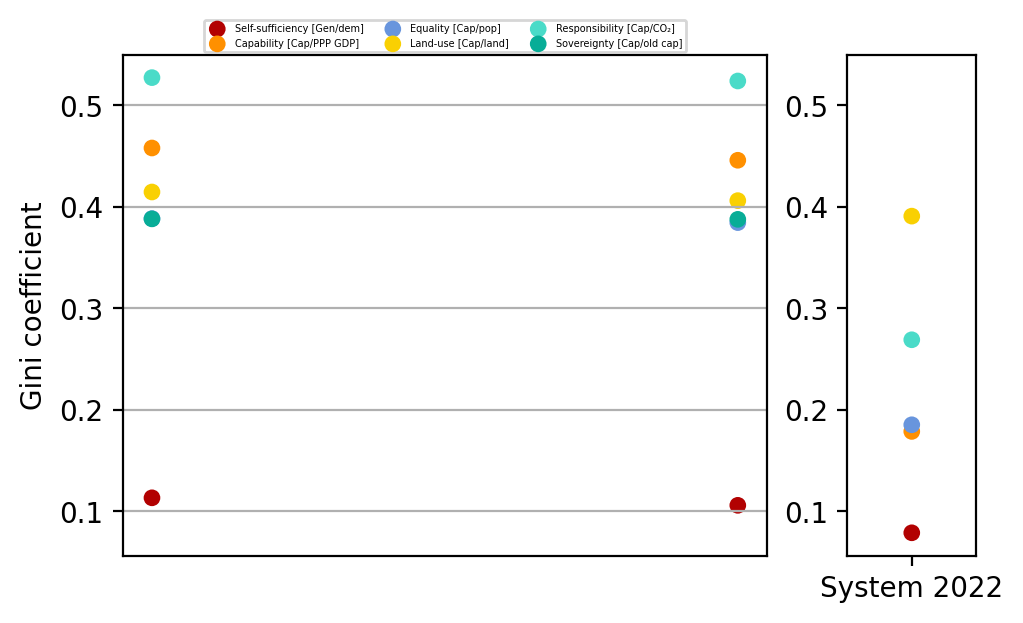

In [52]:
fig = plt.figure(figsize=(5,3), dpi=200,layout="constrained")

gs = fig.add_gridspec(1,2,width_ratios=(5, 1),wspace = 0, )
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1],sharey=ax1)

for principle in principle_list:
    temp = df_gini.loc[df_gini['principle'] == principle]
    x = temp.scenario
    y = temp.gini_c
    ax1.scatter(x, y, c=colordict[principle], label=principle,
               alpha=1, edgecolors='none')

ax1.legend(
    [
        'Self-sufficiency [Gen/dem]',
        'Capability [Cap/PPP GDP]',
#        'Capability [Capacity/per capita GDP]',
        'Equality [Cap/pop]',
        'Land-use [Cap/land]',
        'Responsibility [Cap/CO\N{SUBSCRIPT TWO}]',
        'Sovereignty [Cap/old cap]'],
    ncol=3,
    loc='upper center',
    bbox_to_anchor=[0.5,1.08],
    fontsize = 3.5)

ax1.grid(True)
ax1.set_xticks([])
ax1.set_ylabel('Gini coefficient')


for principle in principle_list_short:
    temp = current_ginis.loc[current_ginis['principle'] == principle]
    x = temp.scenario
    y = temp.gini_c
    ax2.scatter(x, y, c=colordict[principle], label=principle,
               alpha=1, edgecolors='none')

for principle in principle_list:
    temp = df_gini.loc[df_gini['principle'] == principle].query("scenario == ' baseline'")
    x = temp.scenario
    y = temp.gini_c
    ax2.scatter(x, y, c=colordict[principle], label=principle,
               alpha=1, edgecolors='none')

ax2.set(xticklabels=['System 2022','Baseline'])
ax2.margins(x=0.3)

#plt.savefig('figures/gini_scatter.pdf',bbox_inches='tight')
#plt.savefig('figures/gini_scatter.png',bbox_inches='tight')

In [53]:
df_gini.loc[df_gini['principle'] == 'capperpppgdp']

,scenario,gini_c,principle
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp


In [54]:
principle_list

['genperdem',
 'capperpppgdp',
 'capperpop',
 'capperland',
 'capperco2',
 'capperold']

In [55]:
df_gini


,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop
6,NO_Solar_maximizing_0.07,0.414575,capperland
7,SE_Solar_maximizing_0.07,0.406060,capperland
8,NO_Solar_maximizing_0.07,0.527236,capperco2
9,SE_Solar_maximizing_0.07,0.523923,capperco2


In [56]:
top_performers = []
for principle in principle_list:
    temp = df_gini.loc[df_gini['principle'] == principle]
    print(principle + ':' + df_gini.loc[df_gini['principle'] == principle].sort_values(by='gini_c').iloc[0].scenario) 
    top_performers.append(df_gini.loc[df_gini['principle'] == principle].sort_values(by='gini_c').iloc[0].scenario)

top_performers

genperdem:SE_Solar_maximizing_0.07
capperpppgdp:SE_Solar_maximizing_0.07
capperpop:SE_Solar_maximizing_0.07
capperland:SE_Solar_maximizing_0.07
capperco2:SE_Solar_maximizing_0.07
capperold:SE_Solar_maximizing_0.07


['SE_Solar_maximizing_0.07',
 'SE_Solar_maximizing_0.07',
 'SE_Solar_maximizing_0.07',
 'SE_Solar_maximizing_0.07',
 'SE_Solar_maximizing_0.07',
 'SE_Solar_maximizing_0.07']

In [57]:
worst_performers = []
for principle in principle_list:
    temp = df_gini.loc[df_gini['principle'] == principle]
    print(principle + ':' + df_gini.loc[df_gini['principle'] == principle].sort_values(by='gini_c',ascending=False).iloc[0].scenario) 
    worst_performers.append(df_gini.loc[df_gini['principle'] == principle].sort_values(by='gini_c',ascending=False).iloc[0].scenario)

worst_performers

genperdem:NO_Solar_maximizing_0.07
capperpppgdp:NO_Solar_maximizing_0.07
capperpop:NO_Solar_maximizing_0.07
capperland:NO_Solar_maximizing_0.07
capperco2:NO_Solar_maximizing_0.07
capperold:NO_Solar_maximizing_0.07


['NO_Solar_maximizing_0.07',
 'NO_Solar_maximizing_0.07',
 'NO_Solar_maximizing_0.07',
 'NO_Solar_maximizing_0.07',
 'NO_Solar_maximizing_0.07',
 'NO_Solar_maximizing_0.07']

In [58]:
df_gini.loc[df_gini['principle'] == principle].query("scenario == ' baseline'")

,scenario,gini_c,principle


In [59]:
top_performers

['SE_Solar_maximizing_0.07',
 'SE_Solar_maximizing_0.07',
 'SE_Solar_maximizing_0.07',
 'SE_Solar_maximizing_0.07',
 'SE_Solar_maximizing_0.07',
 'SE_Solar_maximizing_0.07']

In [60]:
df_gini.set_index('scenario').loc[top_performers].reset_index()

,scenario,gini_c,principle
0,SE_Solar_maximizing_0.07,0.105923,genperdem
1,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
2,SE_Solar_maximizing_0.07,0.384420,capperpop
3,SE_Solar_maximizing_0.07,0.406060,capperland
4,SE_Solar_maximizing_0.07,0.523923,capperco2
5,SE_Solar_maximizing_0.07,0.387636,capperold
6,SE_Solar_maximizing_0.07,0.105923,genperdem
7,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
8,SE_Solar_maximizing_0.07,0.384420,capperpop
9,SE_Solar_maximizing_0.07,0.406060,capperland


C:\Users\javedm\AppData\Local\Temp\ipykernel_10952\2976004645.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set(xticklabels=['SEMAXSOL07'])
C:\Users\javedm\AppData\Local\Temp\ipykernel_10952\2976004645.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set(xticklabels=['System 2022','Baseline'])


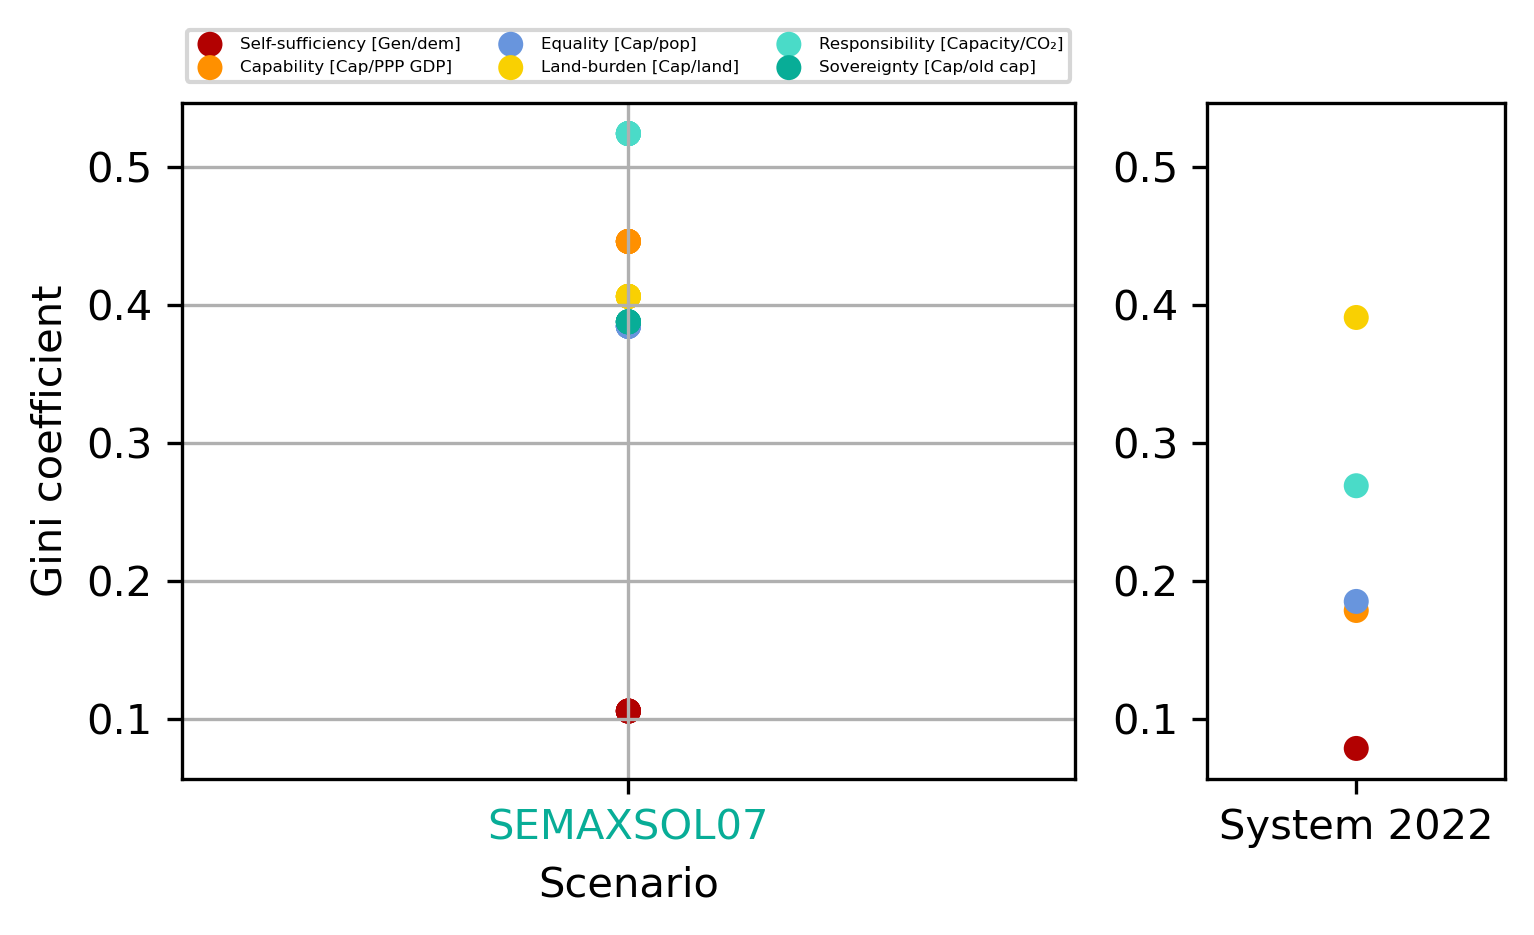

In [61]:
fig = plt.figure(figsize=(5,3),dpi=300,layout="constrained")

gs = fig.add_gridspec(1,2,width_ratios=(3, 1),wspace = 0.05, )
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1],sharey=ax1)


for principle in principle_list:
    temp = df_gini.set_index('scenario').loc[top_performers].reset_index()
    temp = temp.loc[temp['principle'] == principle]
    x = temp.scenario
    y = temp.gini_c
    ax1.scatter(x, y, c=colordict[principle], label=principle,
               alpha=1, edgecolors='none')
    
ax1.legend(['Self-sufficiency [Gen/dem]','Capability [Cap/PPP GDP]','Equality [Cap/pop]','Land-burden [Cap/land]','Responsibility [Capacity/CO\N{SUBSCRIPT TWO}]','Sovereignty [Cap/old cap]'],
           ncol=3,loc='upper center',bbox_to_anchor=[0.5,1.12], fontsize = 4)
ax1.grid(True)
ax1.set(xticklabels=['SEMAXSOL07']) 
#ax1.set(xticklabels=['FRMINOFF10','DEMINON15','UKMAXON10','FIMAXSOL15','EUMAXON15','DEMAXON10'])

count = 0
for color in colordict.values():
    ax1.get_xticklabels()[count].set_color(color)
    #count+=1
ax1.set_ylabel('Gini coefficient')
ax1.set_xlabel('Scenario')

for principle in principle_list:
    temp = current_ginis.loc[current_ginis['principle'] == principle]
    x = temp.scenario
    y = temp.gini_c
    ax2.scatter(x, y, c=colordict[principle], label=principle,
               alpha=1, edgecolors='none')
    
for principle in principle_list:
    temp = df_gini.loc[df_gini['principle'] == principle].query("scenario == ' baseline'")
    x = temp.scenario
    y = temp.gini_c
    ax2.scatter(x, y, c=colordict[principle], label=principle,
               alpha=1, edgecolors='none')

ax2.set(xticklabels=['System 2022','Baseline'])
ax2.margins(x=0.3)

#plt.savefig('figures/top_performers.pdf',bbox_inches='tight')
#plt.savefig('figures/top_performers.png',bbox_inches='tight')
#plt.show()

In [62]:
df_gini.reset_index().drop(columns='index')

,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop
6,NO_Solar_maximizing_0.07,0.414575,capperland
7,SE_Solar_maximizing_0.07,0.406060,capperland
8,NO_Solar_maximizing_0.07,0.527236,capperco2
9,SE_Solar_maximizing_0.07,0.523923,capperco2


In [63]:
top_df = pd.DataFrame(columns=['scenario','principle','gini_c'])

for principle in principle_list:
    temporary = df_gini.loc[df_gini['principle'] == principle].sort_values(by='gini_c').iloc[0]
    new_row = pd.DataFrame({'scenario' : [temporary.scenario], 'principle' : [temporary.principle], 'gini_c' : [temporary.gini_c]})
    top_df = pd.concat([top_df, new_row], ignore_index=True)
    #top_df = top_df.append({'scenario' : temporary.scenario, 'principle' : temporary.principle, 'gini_c' : temporary.gini_c},ignore_index=True)

In [64]:
top_df

,scenario,principle,gini_c
0,SE_Solar_maximizing_0.07,genperdem,0.105923
1,SE_Solar_maximizing_0.07,capperpppgdp,0.445834
2,SE_Solar_maximizing_0.07,capperpop,0.384420
3,SE_Solar_maximizing_0.07,capperland,0.406060
4,SE_Solar_maximizing_0.07,capperco2,0.523923
5,SE_Solar_maximizing_0.07,capperold,0.387636


In [65]:
new_row = pd.DataFrame({'scenario' : ['baseline', 'baseline', 'baseline', 'baseline', 'baseline', 'baseline' ],
                         'principle' : ['genperdem', 'capperpppgdp', 'capperpop', 'capperland', 'capperco2', 'capperold' ],
                          'gini_c' : [0.138, 0.5153,0.425, 0.48547,0.590, 0.4378 ]})
df_gini_base = pd.concat([df_gini, new_row], ignore_index=True)
df_gini_base


,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop
6,NO_Solar_maximizing_0.07,0.414575,capperland
7,SE_Solar_maximizing_0.07,0.406060,capperland
8,NO_Solar_maximizing_0.07,0.527236,capperco2
9,SE_Solar_maximizing_0.07,0.523923,capperco2


In [66]:
(
    top_df
    .merge(df_gini_base.query("scenario == 'baseline'"),left_on = 'principle',right_on = 'principle')
    .rename(columns={'scenario_x' : 'scenario', 'gini_c_x' : 'gini_c', 'gini_c_y' : 'baseline'})
    .drop(columns={'scenario_y'})
    .assign(abs_difference = lambda x : x.baseline - x.gini_c, perc_difference = lambda x : (x.abs_difference/x.baseline).mul(100))
)

,scenario,principle,gini_c,baseline,abs_difference,perc_difference
0,SE_Solar_maximizing_0.07,genperdem,0.105923,0.13800,0.032077,23.243962
1,SE_Solar_maximizing_0.07,capperpppgdp,0.445834,0.51530,0.069466,13.480622
2,SE_Solar_maximizing_0.07,capperpop,0.384420,0.42500,0.040580,9.548208
3,SE_Solar_maximizing_0.07,capperland,0.406060,0.48547,0.079410,16.357271
4,SE_Solar_maximizing_0.07,capperco2,0.523923,0.59000,0.066077,11.199522
5,SE_Solar_maximizing_0.07,capperold,0.387636,0.43780,0.050164,11.458221


In [67]:
df_score_wide = df_score.set_index(['scenario','zone','principle']).reset_index().sort_values(by = 'zone')
df_score_wide


,scenario,zone,principle,score
220,SE_Solar_maximizing_0.07,AT,capperland,0.065881
333,SE_Solar_maximizing_0.07,AT,capperold,0.048898
26,NO_Solar_maximizing_0.07,AT,genperdem,0.056423
277,SE_Solar_maximizing_0.07,AT,capperco2,0.049029
105,SE_Solar_maximizing_0.07,AT,capperpppgdp,0.038306
...,...,...,...,...
212,SE_Solar_maximizing_0.07,UK,capperland,0.033458
283,NO_Solar_maximizing_0.07,UK,capperold,0.014504
311,SE_Solar_maximizing_0.07,UK,capperold,0.015666
253,SE_Solar_maximizing_0.07,UK,capperco2,0.005924


In [68]:
df_current = df_current.drop(columns={'country', 'technology'})
df_current

,installed_capacity_MW,demand,land,emissions_1900_2021,gdp_nom,population,demand_MWh,generation_MWh
country_code,,,,,,,,
AT,23868.0,1.274303e+05,82520,5.012390e+09,433258,8932664,6.302371e+07,5.171917e+07
BE,25585.0,1.739532e+05,30280,1.113623e+10,521861,11554767,8.580761e+07,8.869037e+07
BG,13585.0,7.497775e+04,108560,3.872116e+09,69889,6916548,3.823489e+07,4.993473e+07
CH,15844.0,1.261205e+05,39516,2.976398e+09,752248,8670300,6.239260e+07,3.673510e+07
CZ,19703.0,1.310577e+05,77200,1.143884e+10,245339,10701777,6.464877e+07,7.780997e+07
DE,223119.0,1.034011e+06,349380,8.689965e+10,3846413,83155031,5.118840e+08,4.789840e+08
DK,16666.0,6.908834e+04,40000,4.019912e+09,356084,5840045,3.384888e+07,3.403758e+07
EE,2402.0,1.691337e+04,43470,1.632597e+09,30650,1330068,8.307126e+06,7.173110e+06
ES,112424.0,5.093293e+05,499603,1.487619e+10,1281484,47398695,2.551387e+08,2.613573e+08


In [69]:
df_selfsuf = (
    df_current
    .assign(
        share_gen = lambda x : x.generation_MWh/x.generation_MWh.sum(),
        share_dem = lambda x : x.demand/x.demand.sum(),
        self_suf = lambda x : x.generation_MWh/x.demand,) # Self-sufficiency
    .sort_values('self_suf',ascending=True)
    .assign(
        cumulative_gen = lambda x: x.share_gen.cumsum(),
        cumulative_dem = lambda x: x.share_dem.cumsum(),
        score = lambda x: x.share_gen * (x.share_dem + 2*(1-x.cumulative_dem)))
)

gini = 1-df_selfsuf.score.sum()
new_row = pd.DataFrame({'scenario' : ['Current system'], 'gini_c' : [gini], 'principle' : ['genperdem']})
df_gini_base = pd.concat([df_gini_base, new_row], ignore_index=True)
#df_gini = df_gini.append({'scenario' : 'Current system', 'gini_c' : gini, 'principle' : 'genperdem'},ignore_index=True)
df_gini_base

,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop
6,NO_Solar_maximizing_0.07,0.414575,capperland
7,SE_Solar_maximizing_0.07,0.406060,capperland
8,NO_Solar_maximizing_0.07,0.527236,capperco2
9,SE_Solar_maximizing_0.07,0.523923,capperco2


In [70]:
df_equal = (
    df_current
    .assign(
        share_cap = lambda x : x.installed_capacity_MW/x.installed_capacity_MW.sum(),
        share_pop = lambda x : x.population/x.population.sum(),
        capperpop = lambda x : x.installed_capacity_MW/x.population)
    .sort_values('capperpop',ascending=True)
    .assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_pop = lambda x: x.share_pop.cumsum(),
        score = lambda x: x.share_cap * (x.share_pop + 2*(1-x.cumulative_pop)))
)

gini = 1-df_equal.score.sum()
new_row = pd.DataFrame({'scenario' : ['Current system'], 'gini_c' : [gini], 'principle' : ['capperpop']})
df_gini_base = pd.concat([df_gini_base, new_row], ignore_index=True)
#df_gini = df_gini.append({'scenario' : 'Current system', 'gini_c' : gini, 'principle' : 'capperpop'},ignore_index=True)
df_gini_base

,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop
6,NO_Solar_maximizing_0.07,0.414575,capperland
7,SE_Solar_maximizing_0.07,0.406060,capperland
8,NO_Solar_maximizing_0.07,0.527236,capperco2
9,SE_Solar_maximizing_0.07,0.523923,capperco2


In [71]:
df_capable = (
    df_current
    .assign(
        share_cap = lambda x : x.installed_capacity_MW/x.installed_capacity_MW.sum(),
        share_gdp = lambda x : x.gdp_nom/x.gdp_nom.sum(),
        cappergdp = lambda x : x.installed_capacity_MW/x.gdp_nom,)
    .sort_values('cappergdp',ascending=True)
    .assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_gdp = lambda x: x.share_gdp.cumsum(),
        score = lambda x: x.share_cap * (x.share_gdp + 2*(1-x.cumulative_gdp)))
)

gini = 1-df_capable.score.sum()
new_row = pd.DataFrame({'scenario' : ['Current system'], 'gini_c' : [gini], 'principle' : ['capperpppgdp']})
df_gini_base = pd.concat([df_gini_base, new_row], ignore_index=True)
#df_gini = df_gini.append({'scenario' : 'Current system', 'gini_c' : gini, 'principle' : 'capperpppgdp'},ignore_index=True)
df_gini_base

,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop
6,NO_Solar_maximizing_0.07,0.414575,capperland
7,SE_Solar_maximizing_0.07,0.406060,capperland
8,NO_Solar_maximizing_0.07,0.527236,capperco2
9,SE_Solar_maximizing_0.07,0.523923,capperco2


In [72]:
df_history = (
    df_current
    .assign(
        share_cap = lambda x : x.installed_capacity_MW/x.installed_capacity_MW.sum(),
        share_co2 = lambda x : x.emissions_1900_2021/x.emissions_1900_2021.sum(),
        capperco2 = lambda x : x.installed_capacity_MW/x.emissions_1900_2021,)
    .sort_values('capperco2',ascending=True)
    .assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_co2 = lambda x: x.share_co2.cumsum(),
        score = lambda x: x.share_cap * (x.share_co2 + 2*(1-x.cumulative_co2)))
)

gini = 1-df_history.score.sum()
new_row = pd.DataFrame({'scenario' : ['Current system'], 'gini_c' : [gini], 'principle' : ['capperco2']})
df_gini_base = pd.concat([df_gini_base, new_row], ignore_index=True)
#df_gini = df_gini.append({'scenario' : 'Current system', 'gini_c' : gini, 'principle' : 'capperco2'},ignore_index=True)

In [73]:
df_gini_base

,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop
6,NO_Solar_maximizing_0.07,0.414575,capperland
7,SE_Solar_maximizing_0.07,0.406060,capperland
8,NO_Solar_maximizing_0.07,0.527236,capperco2
9,SE_Solar_maximizing_0.07,0.523923,capperco2


In [74]:
df_landburd = (
    df_current
    .assign(
        share_cap = lambda x : x.installed_capacity_MW/x.installed_capacity_MW.sum(),
        share_land = lambda x : x.land/x.land.sum(),
        capperland = lambda x : x.installed_capacity_MW/x.land)
    .sort_values('capperland',ascending=True)
    .assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_land = lambda x: x.share_land.cumsum(),
        score = lambda x: x.share_cap * (x.share_land + 2*(1-x.cumulative_land)))
)

gini = 1-df_landburd.score.sum()
new_row = pd.DataFrame({'scenario' : ['Current system'], 'gini_c' : [gini], 'principle' : ['capperland']})
df_gini_base = pd.concat([df_gini_base, new_row], ignore_index=True)
#df_gini = df_gini.append({'scenario' : 'Current system', 'gini_c' : gini, 'principle' : 'capperland'},ignore_index=True)
df_gini_base

,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop
6,NO_Solar_maximizing_0.07,0.414575,capperland
7,SE_Solar_maximizing_0.07,0.406060,capperland
8,NO_Solar_maximizing_0.07,0.527236,capperco2
9,SE_Solar_maximizing_0.07,0.523923,capperco2


C:\Users\javedm\AppData\Local\Temp\ipykernel_10952\332748120.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


Text(0, 0.5, '')

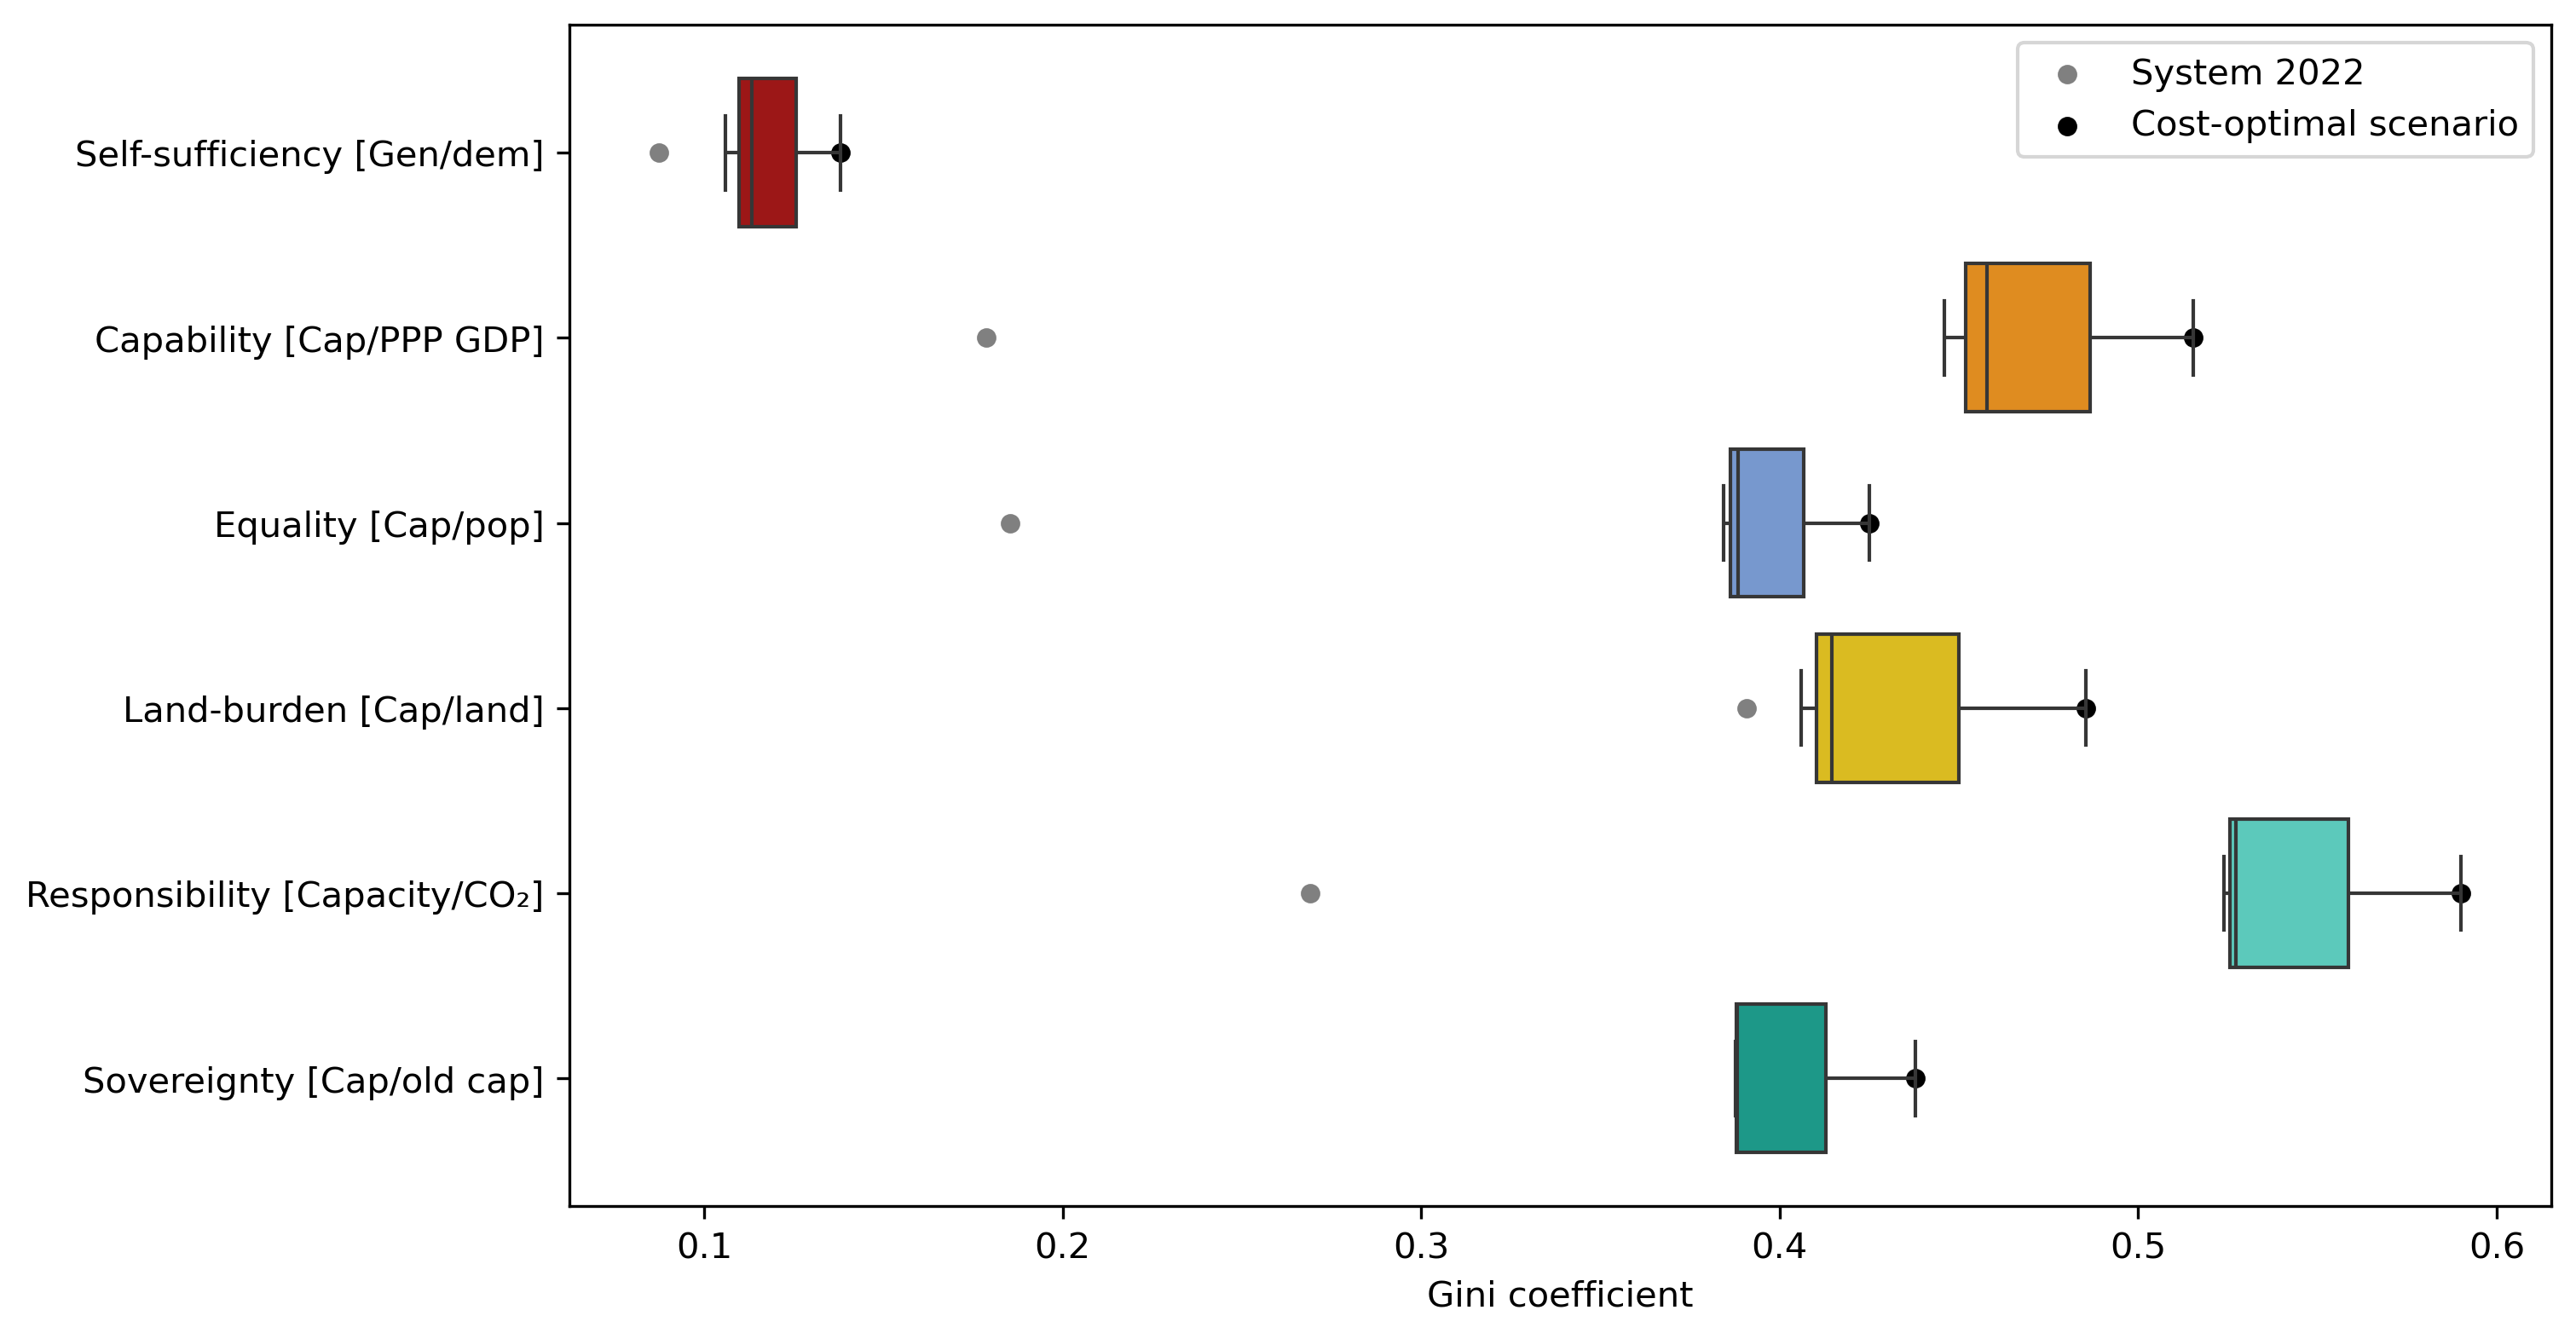

In [75]:
fig, ax = plt.subplots(1,1, figsize = (10,6),dpi=300)
special_cases = ['Current system',' baseline']
sns.boxplot(
        ax=ax,
        x='gini_c', 
        y='principle', 
        data=df_gini_base.query("scenario != @special_cases"), 
        showfliers=False, 
        #color='tomato',
        palette = colordict,
        #hue='scenario',
        #labels = None,
    )
df_gini_current = df_gini_base.query("scenario == 'Current system'").loc[:,['principle','gini_c']]
df_gini_optimal = df_gini_base.query("scenario == 'baseline'").loc[:,['principle','gini_c']]

df_gini_current.principle = pd.Categorical(df_gini_current.principle, ['genperdem','capperpppgdp','capperpop','capperland','capperco2'])
df_gini_optimal.principle = pd.Categorical(df_gini_optimal.principle, ['genperdem','capperpppgdp','capperpop','capperland','capperco2','capperold'])

df_gini_current.sort_values('principle').plot.scatter(ax = ax, x='gini_c', y='principle',color='grey',label = 'System 2022')
df_gini_optimal.sort_values('principle').plot.scatter(ax = ax, x='gini_c', y='principle',color='black',label = 'Cost-optimal scenario')

labels = ['Self-sufficiency [Gen/dem]','Capability [Cap/PPP GDP]','Equality [Cap/pop]','Land-burden [Cap/land]','Responsibility [Capacity/CO\N{SUBSCRIPT TWO}]','Sovereignty [Cap/old cap]']

ax.set_xlabel('Gini coefficient')

ax.set_yticklabels(labels)
ax.set_ylabel('')

#plt.savefig('figures/dispersion_gini_boxplot.png',bbox_inches='tight')
#plt.savefig('figures/dispersion_gini_boxplot.svg',bbox_inches='tight')
#plt.savefig('figures/dispersion_gini_boxplot.pdf',bbox_inches='tight')

<Axes: xlabel='scenario', ylabel='gini_c'>

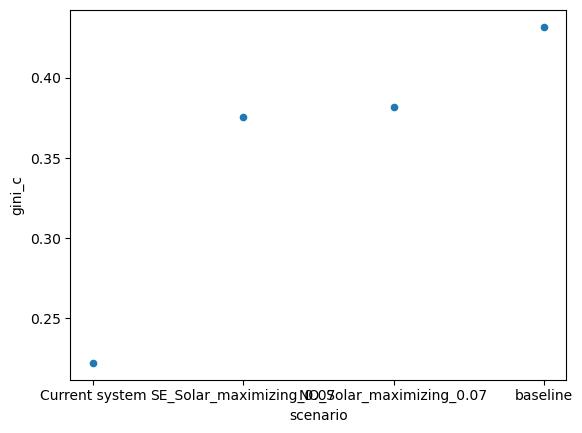

In [76]:
df_gini_base.groupby('scenario')['gini_c'].mean().sort_values().reset_index().plot.scatter(x='scenario',y='gini_c')
#df_gini.groupby('scenario').mean().sort_values(by='gini_c').reset_index().plot.scatter(x='scenario',y='gini_c')

In [77]:
df_wide = p_cap2.loc[slice(None),slice(None),slice(None),'level'].reset_index().groupby(['scenario','zone']).sum().reset_index()
df_wide = df_wide.drop(columns={'technology'})
df_wide

,scenario,zone,installed_capacity_GW
0,NO_Solar_maximizing_0.07,AT,151.839466
1,NO_Solar_maximizing_0.07,BE,50.199689
2,NO_Solar_maximizing_0.07,BG,61.694410
3,NO_Solar_maximizing_0.07,CH,82.398686
4,NO_Solar_maximizing_0.07,CZ,83.298628
5,NO_Solar_maximizing_0.07,DE,403.869398
6,NO_Solar_maximizing_0.07,DK,49.790192
7,NO_Solar_maximizing_0.07,EE,10.358917
8,NO_Solar_maximizing_0.07,ES,383.171414
9,NO_Solar_maximizing_0.07,FI,54.543504


<Axes: xlabel='zone', ylabel='installed_capacity_GW'>

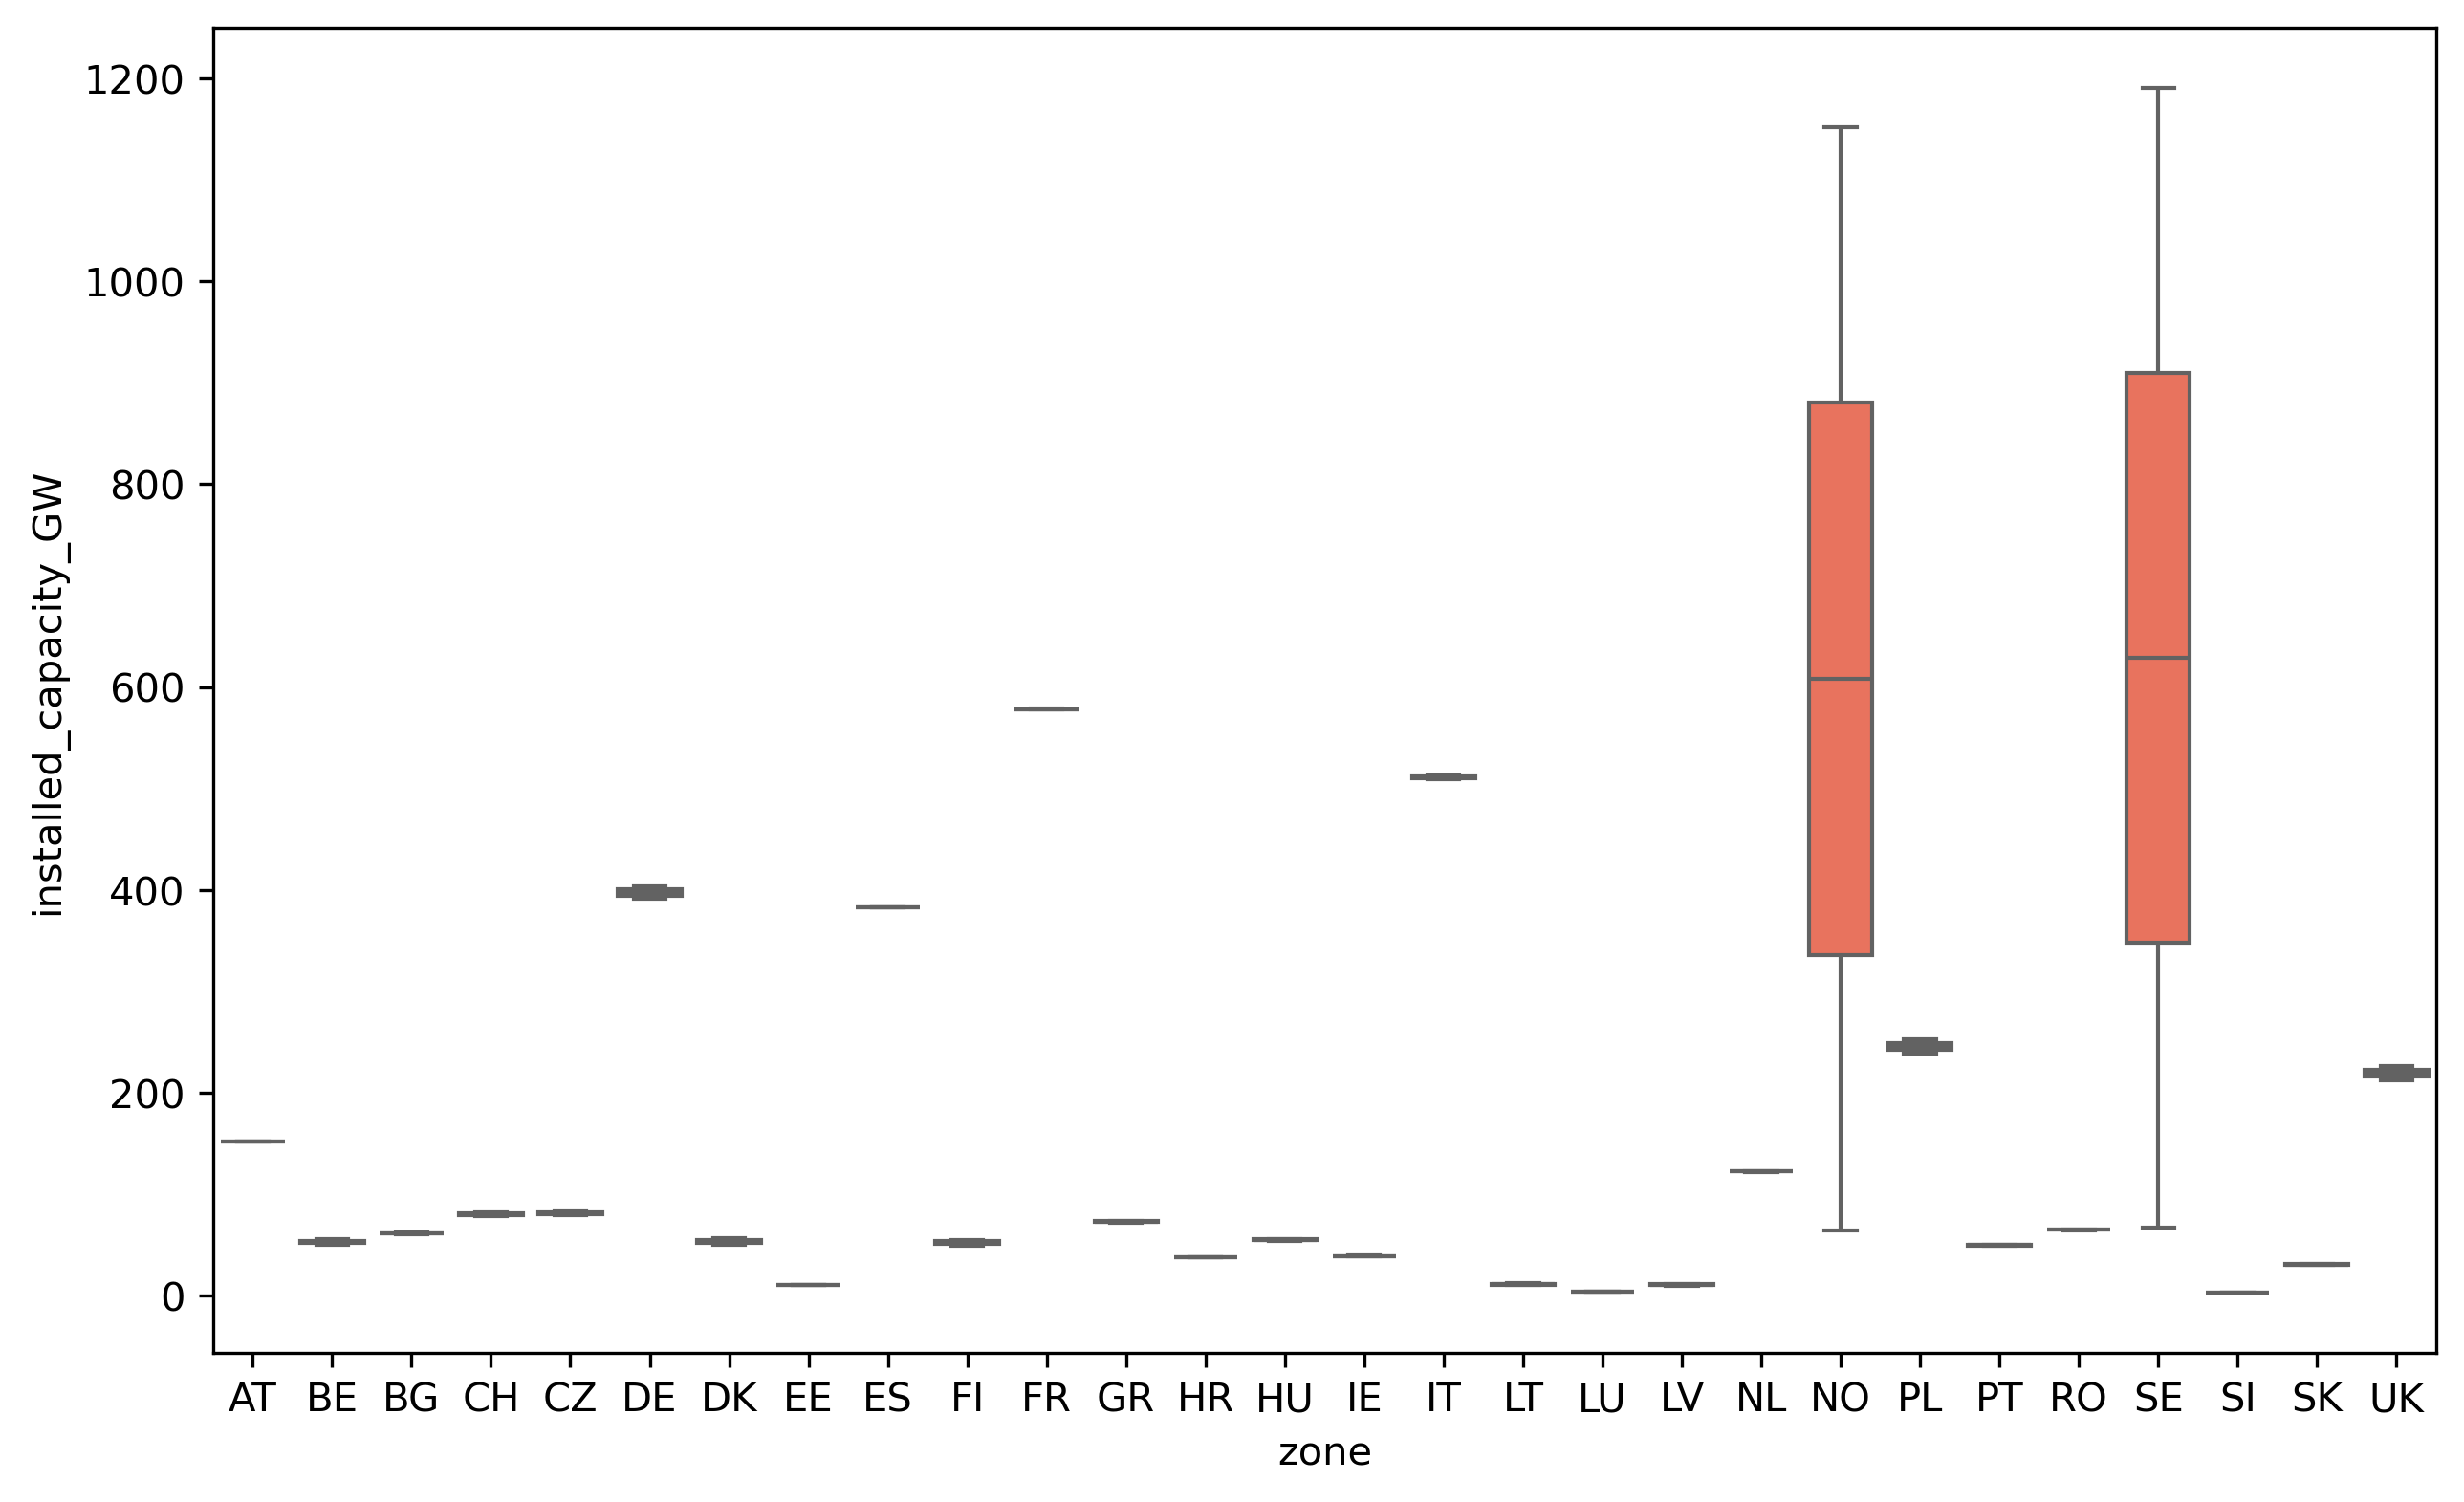

In [78]:
fig, ax = plt.subplots(1,1, figsize = (10,6),dpi=300)

sns.boxplot(
        ax=ax,
        x='zone', 
        y='installed_capacity_GW', 
        data=df_wide, 
        showfliers=False, 
        color='tomato', 
        #hue='scenario',
        #labels = None,
    ) 

In [79]:
df_wide2 = p_cap2.loc[slice(None),slice(None),slice(None),'level'].reset_index().groupby(['scenario','technology']).sum().reset_index()
df_wide2 = df_wide2.drop(columns={'zone'})
df_wide2

,scenario,technology,installed_capacity_GW
0,NO_Solar_maximizing_0.07,HydroRes,9.400671e+01
1,NO_Solar_maximizing_0.07,HydroRoR,6.536253e+01
2,NO_Solar_maximizing_0.07,NaturalgasCCGTwithCCSnewOT,2.260303e+02
3,NO_Solar_maximizing_0.07,NaturalgasOCGTnew,6.466279e+01
4,NO_Solar_maximizing_0.07,NuclearEPR,1.628641e-07
5,NO_Solar_maximizing_0.07,Solar,3.094050e+03
6,NO_Solar_maximizing_0.07,Windoffshore,5.795798e+02
7,NO_Solar_maximizing_0.07,Windonshore,4.754537e+02
8,SE_Solar_maximizing_0.07,HydroRes,9.400671e+01
9,SE_Solar_maximizing_0.07,HydroRoR,6.536253e+01


<Axes: xlabel='technology', ylabel='installed_capacity_GW'>

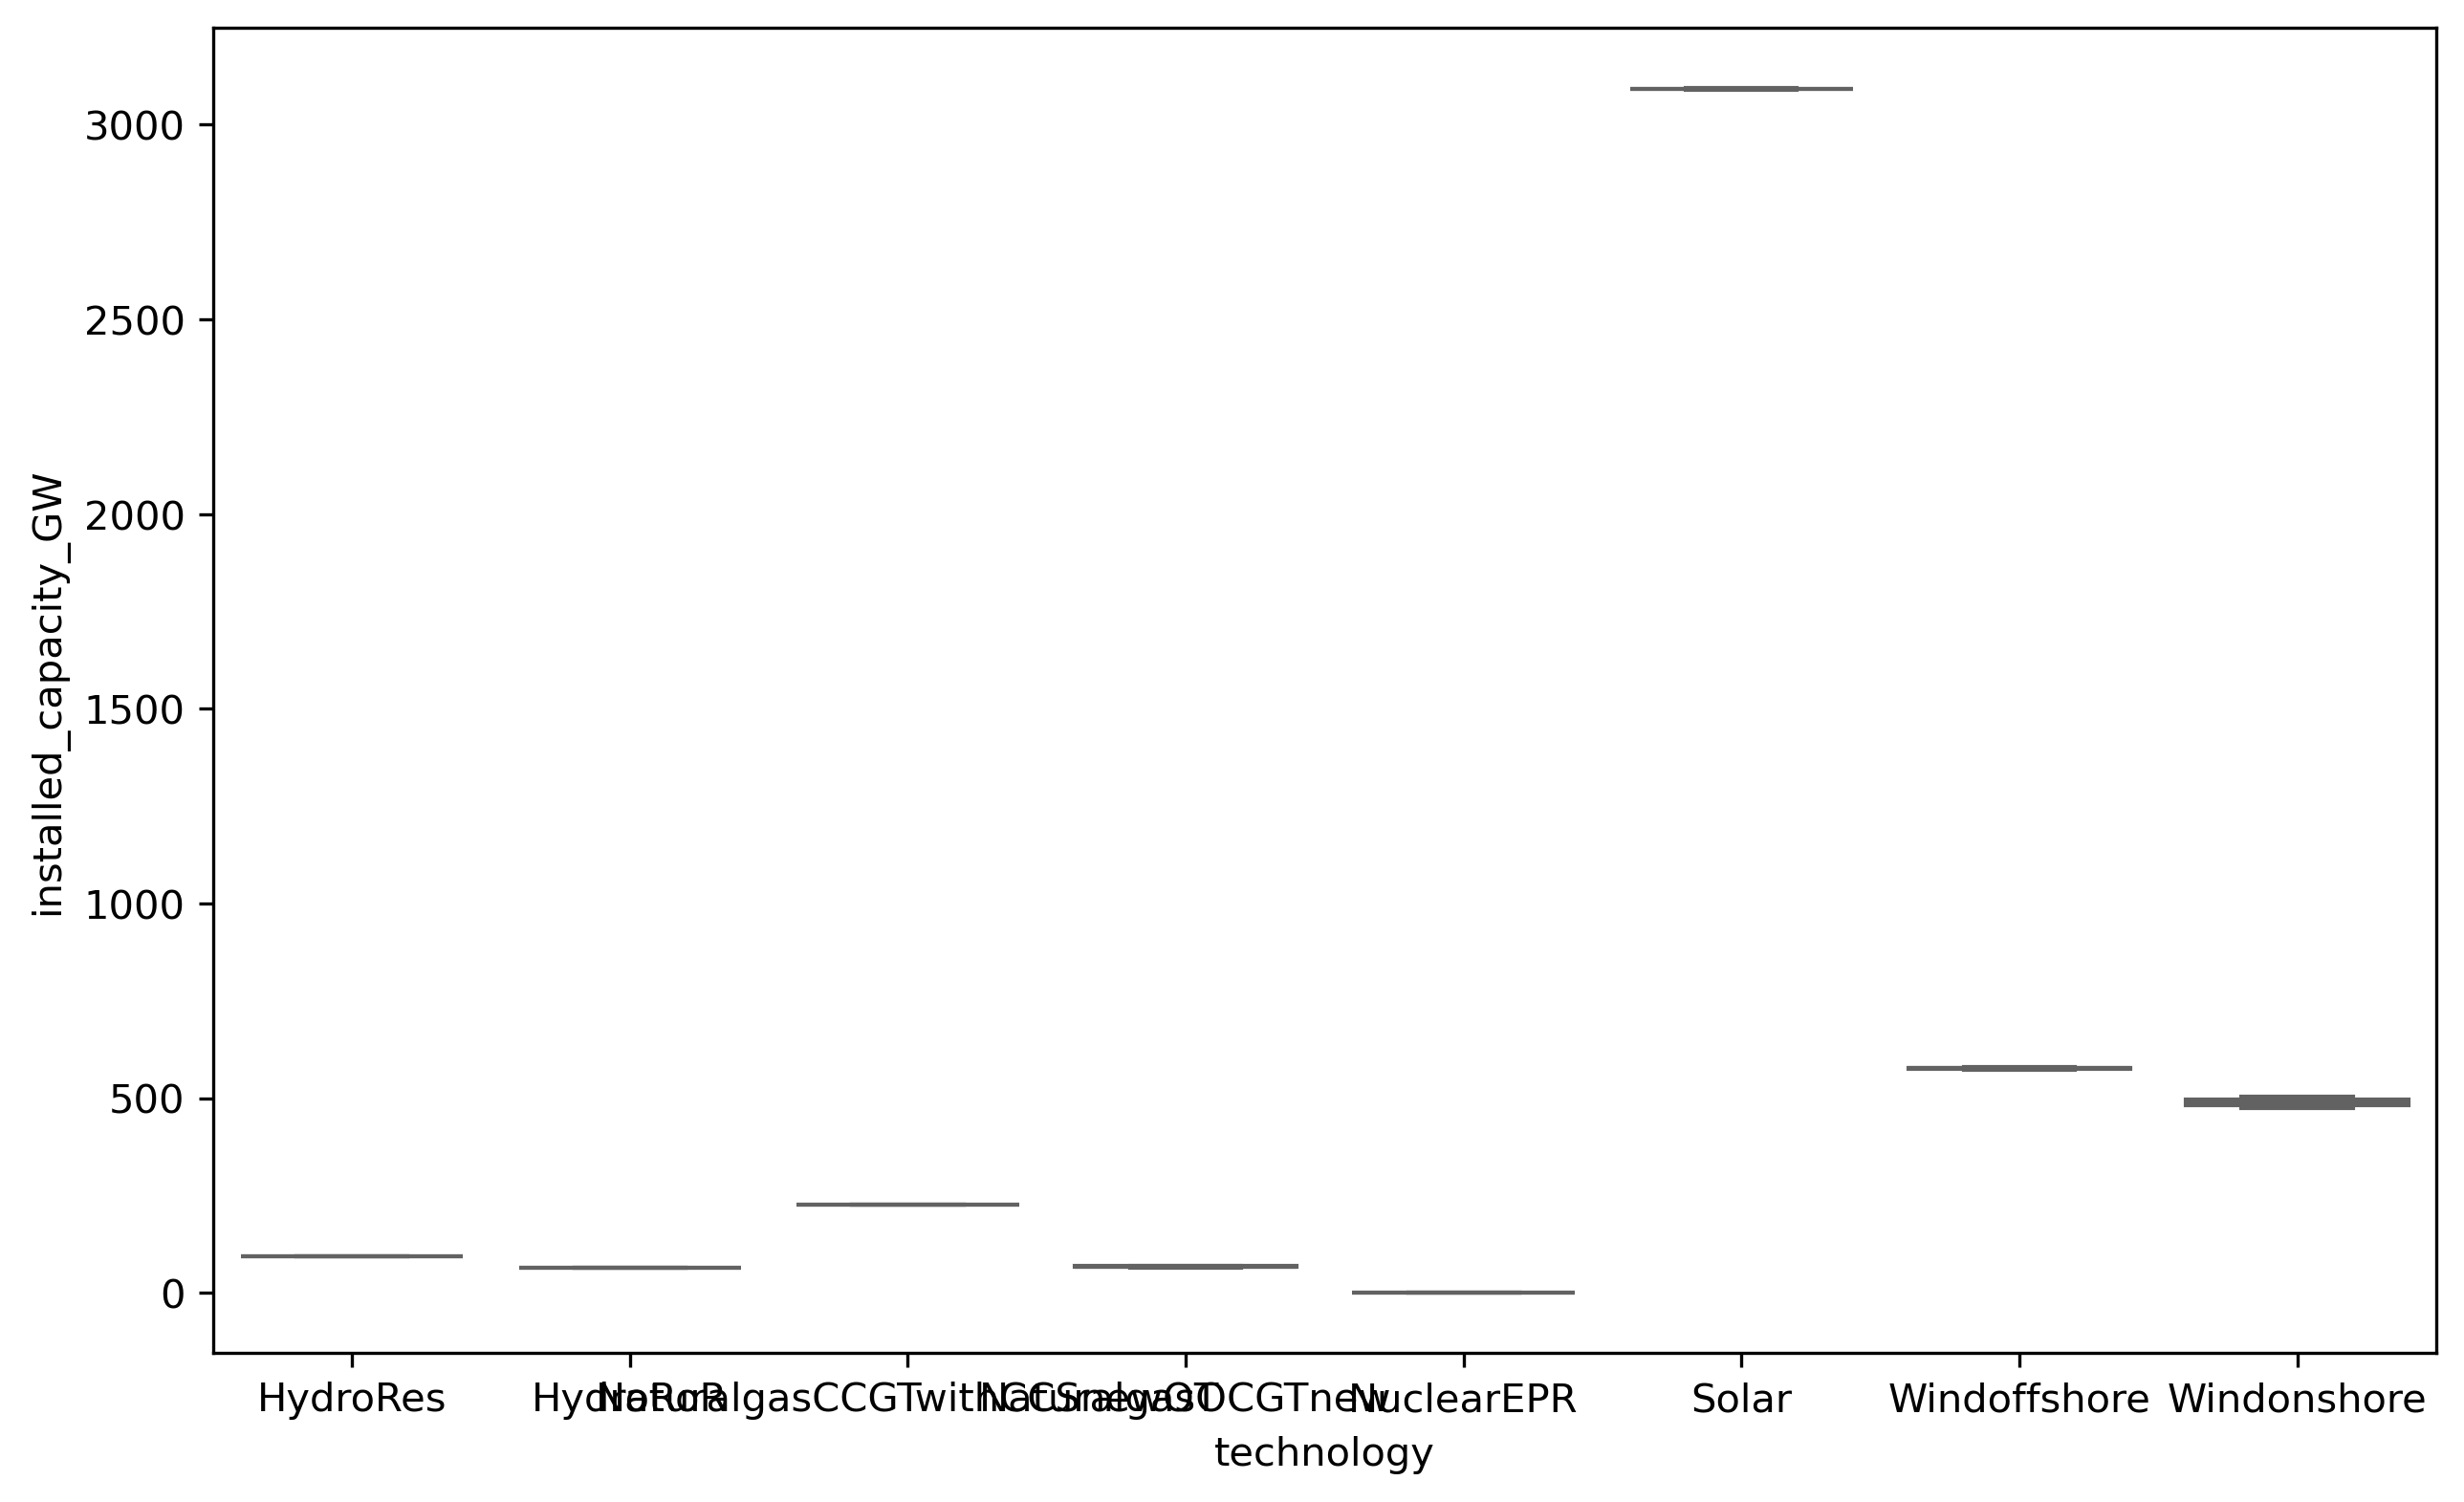

In [80]:
fig, ax = plt.subplots(1,1, figsize = (10,6),dpi=300)

sns.boxplot(
        ax=ax,
        x='technology', 
        y='installed_capacity_GW', 
        data=df_wide2, 
        showfliers=True, 
        color='tomato', 
        #hue='scenario',
        #labels = None,
    )  

In [81]:
df_better = pd.DataFrame()

for principle in principle_list:
    df_better_scenarios = pd.DataFrame()
    threshold = df_gini_base.query("scenario == 'baseline' & principle == @principle").gini_c.values[0]
    add_list = df_gini_base.query("scenario != 'baseline' & principle == @principle & gini_c < @threshold").scenario.to_frame()
    frames = [df_better_scenarios, add_list]
    df_better_scenarios = pd.concat(frames)
    #df_better_scenarios = df_better_scenarios.append(add_list)
    df_better_scenarios = df_better_scenarios.assign(principle = str(principle))
    new_row = [df_better, df_better_scenarios]
    df_better = pd.concat(new_row)
    #df_better = df_better.append(df_better_scenarios)

In [82]:
df_better

,scenario,principle
0,NO_Solar_maximizing_0.07,genperdem
1,SE_Solar_maximizing_0.07,genperdem
18,Current system,genperdem
2,NO_Solar_maximizing_0.07,capperpppgdp
3,SE_Solar_maximizing_0.07,capperpppgdp
20,Current system,capperpppgdp
4,NO_Solar_maximizing_0.07,capperpop
5,SE_Solar_maximizing_0.07,capperpop
19,Current system,capperpop
6,NO_Solar_maximizing_0.07,capperland


In [83]:
df_wide2.query("technology == 'Solar'")

,scenario,technology,installed_capacity_GW
5,NO_Solar_maximizing_0.07,Solar,3094.050296
13,SE_Solar_maximizing_0.07,Solar,3090.651025


In [84]:
technology = 'Solar'
(
    p_cap2
    .loc[('SE_Solar_maximizing_0.07',slice(None),slice(None),'level')]
    .groupby('technology').sum()
    .reset_index()
    .query("technology == @technology")
    #.plot.scatter(ax=axes[axis_nr],x = 'technology',y='installed_capacity_GW')
)

,technology,installed_capacity_GW
5,Solar,3090.651025


In [85]:
p_cap2.loc[('NO_Solar_maximizing_0.07',slice(None),slice(None),'level')].groupby('technology').sum()

,installed_capacity_GW
technology,
HydroRes,9.400671e+01
HydroRoR,6.536253e+01
NaturalgasCCGTwithCCSnewOT,2.260303e+02
NaturalgasOCGTnew,6.466279e+01
NuclearEPR,1.628641e-07
Solar,3.094050e+03
Windoffshore,5.795798e+02
Windonshore,4.754537e+02


# Box plots with for loop

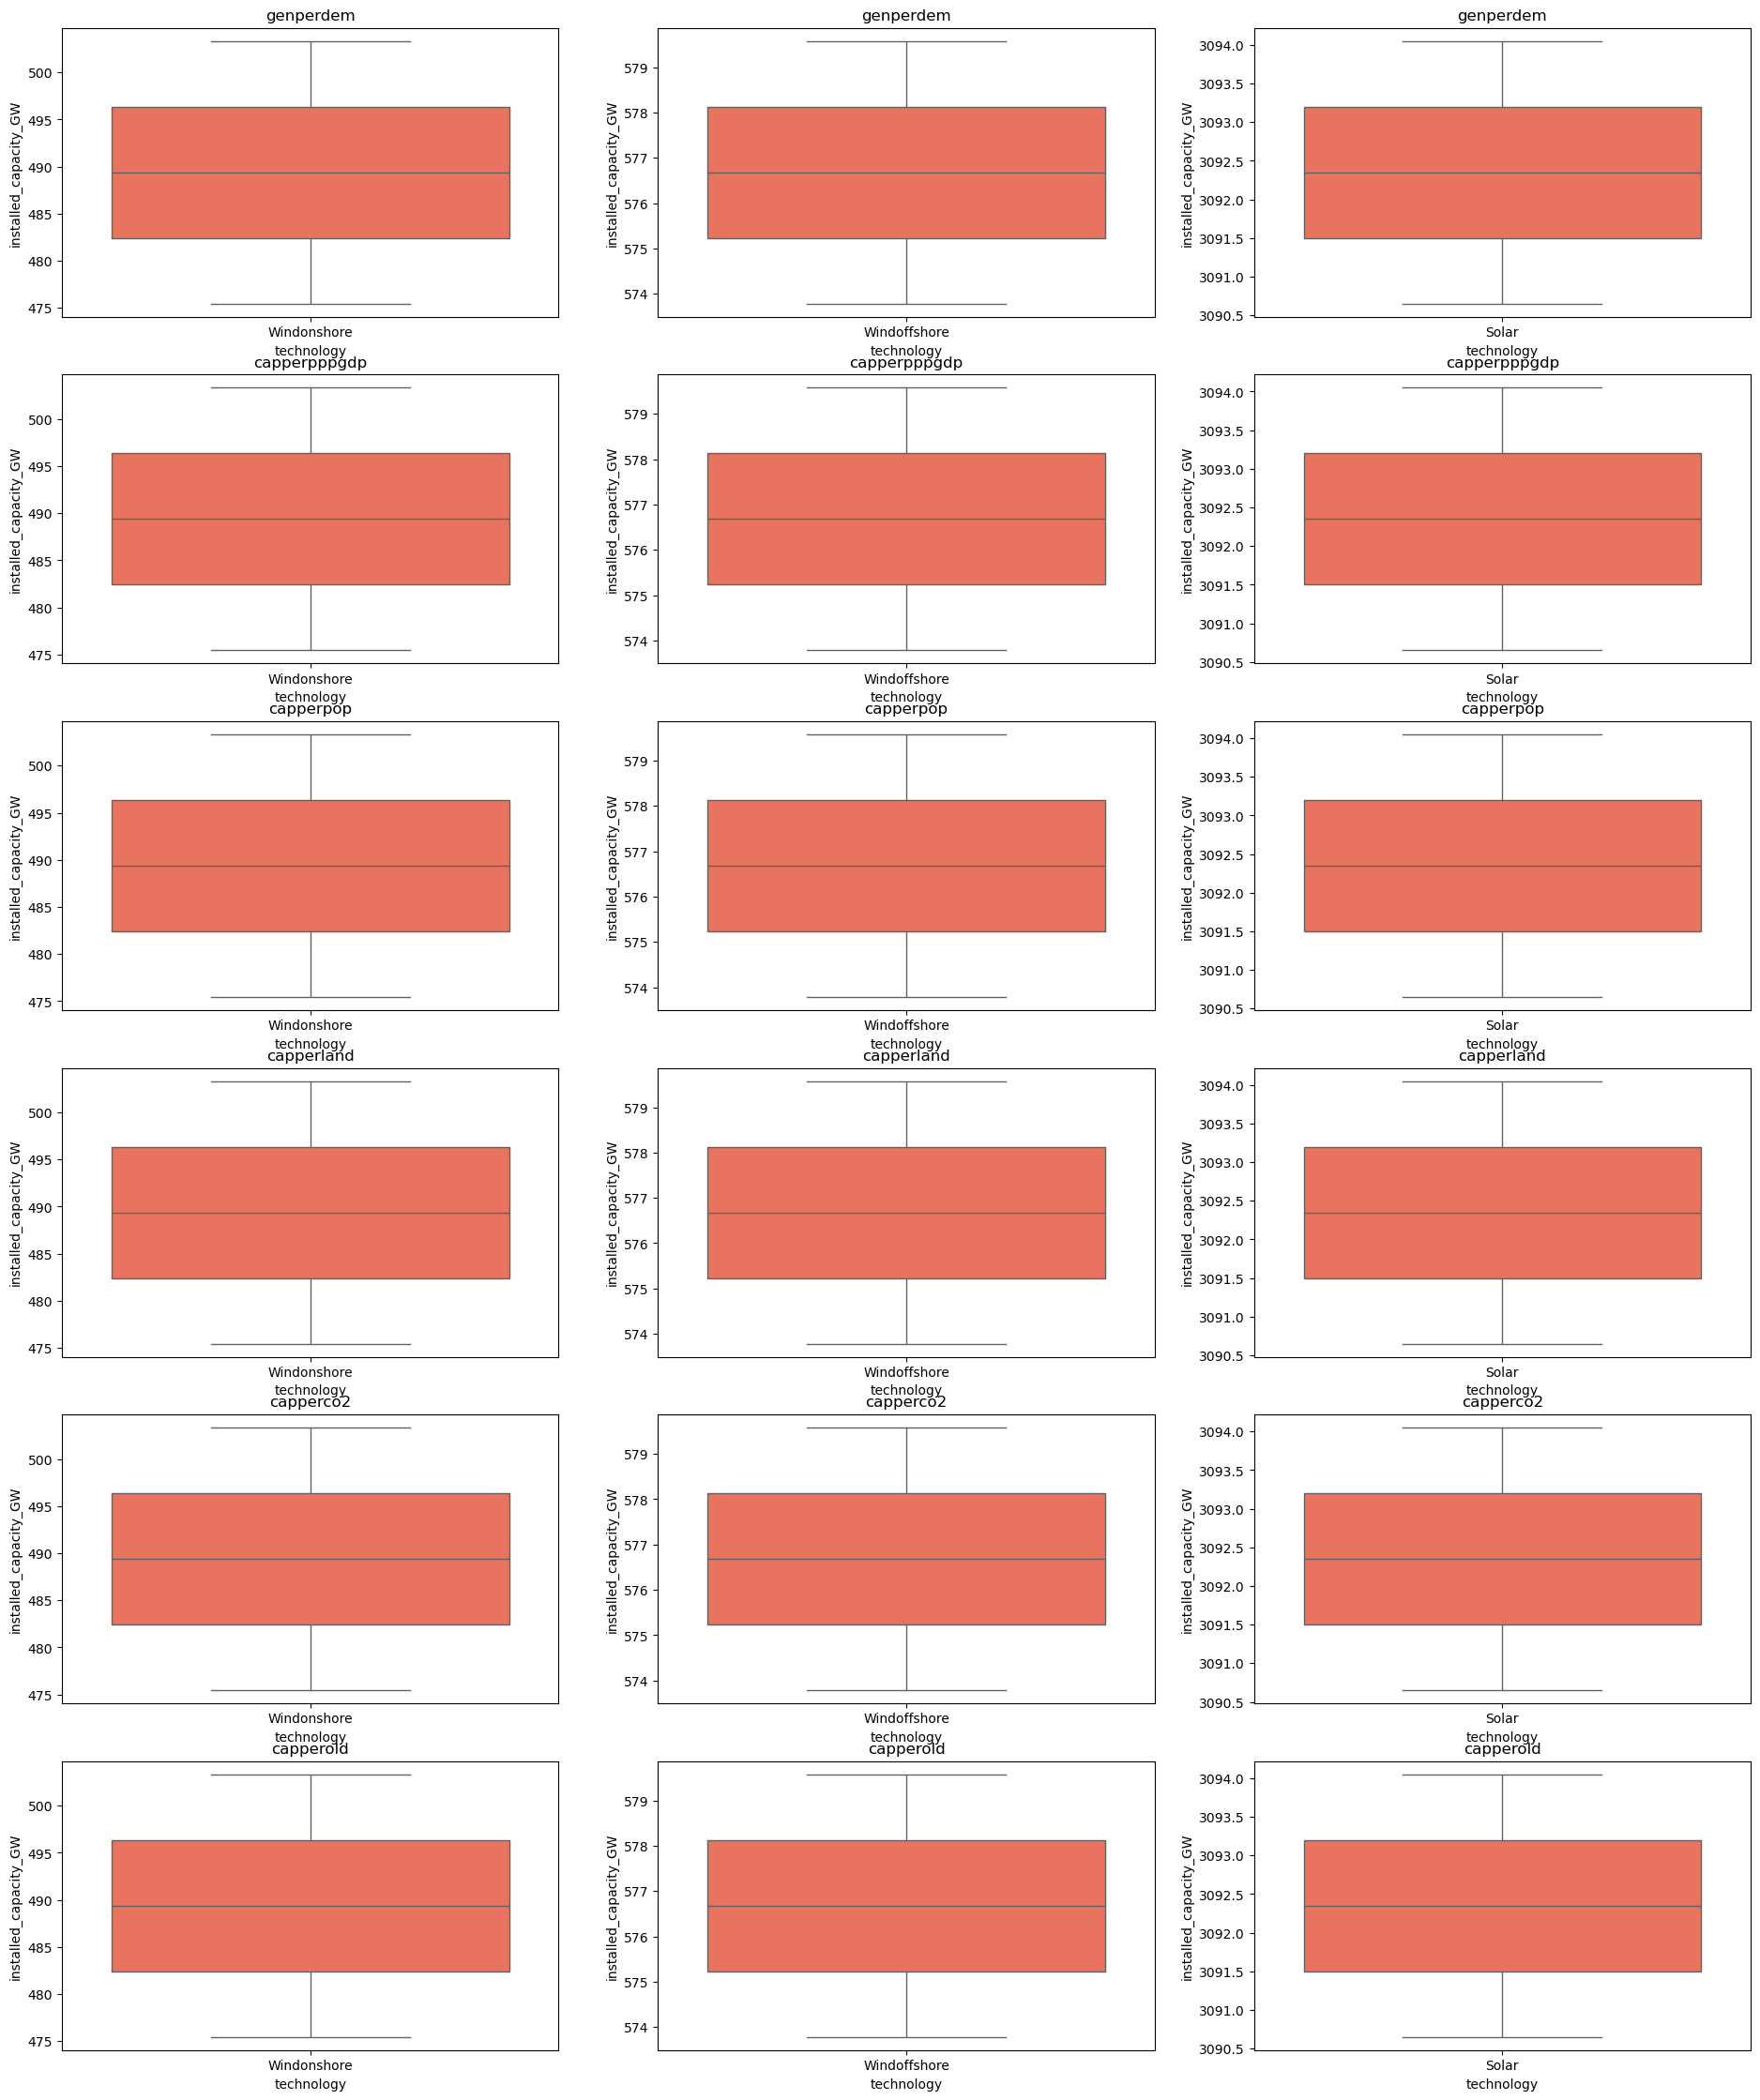

In [104]:
technologies = ['Windonshore','Windoffshore','Solar']

number_rows = len(principle_list)
number_cols = len(technologies)

fig, axes = plt.subplots(number_rows,number_cols,figsize=(9,28))
fig.subplots_adjust(left=0, right=2)

df_better.query("principle == 'genperdem'").scenario.to_list()

row = 0
column = 0
count = 0

for principle in principle_list:
    filter_better = df_better.query("principle == @principle").scenario.to_list()
    
    for technology in technologies:
        sns.boxplot(
            ax=axes[row,column],
            x='technology', 
            y='installed_capacity_GW', 
            data=df_wide2.query("technology == @technology & scenario == @filter_better"),  #box plot each tech installed capacity under all scenarios 
            showfliers=False, 
            color='tomato', 
            #hue='scenario',
            #labels = None,
        )

        (   #it requires baseline scenario, thatswhy not working
            #p_cap2
            #.loc[('baseline',slice(None),slice(None),'level')]      #now there is no baseline scenario in p_cap2
            #.groupby('technology').sum()
            #.reset_index()
            #.query("technology == @technology")
            #.plot.scatter(ax=axes[row,column],x = 'technology',y='installed_capacity_GW',s=100)
        )

        axes[row,column].set_title(principle)
        count += 1
        if column < number_cols-1:
            column += 1
        else:
            column = 0
            row += 1         




In [105]:
p_cap2

installed_capacity_GW
scenario                 zone technology   type                           
NO_Solar_maximizing_0.07 AT   HydroRes     level              2.964900e+00
                                           lo                 2.964900e+00
                                           marginal           9.570934e+00
                                           up                 2.964900e+00
                              HydroRoR     level              5.542700e+00
...                                                                    ...
SE_Solar_maximizing_0.07 UK   Windoffshore up                1.000000e+100
                              Windonshore  level              1.970935e+01
                                           lo                 0.000000e+00
                                           marginal           0.000000e+00
                                           up                1.000000e+100

[1792 rows x 1 columns]

# Violan plots with for loop

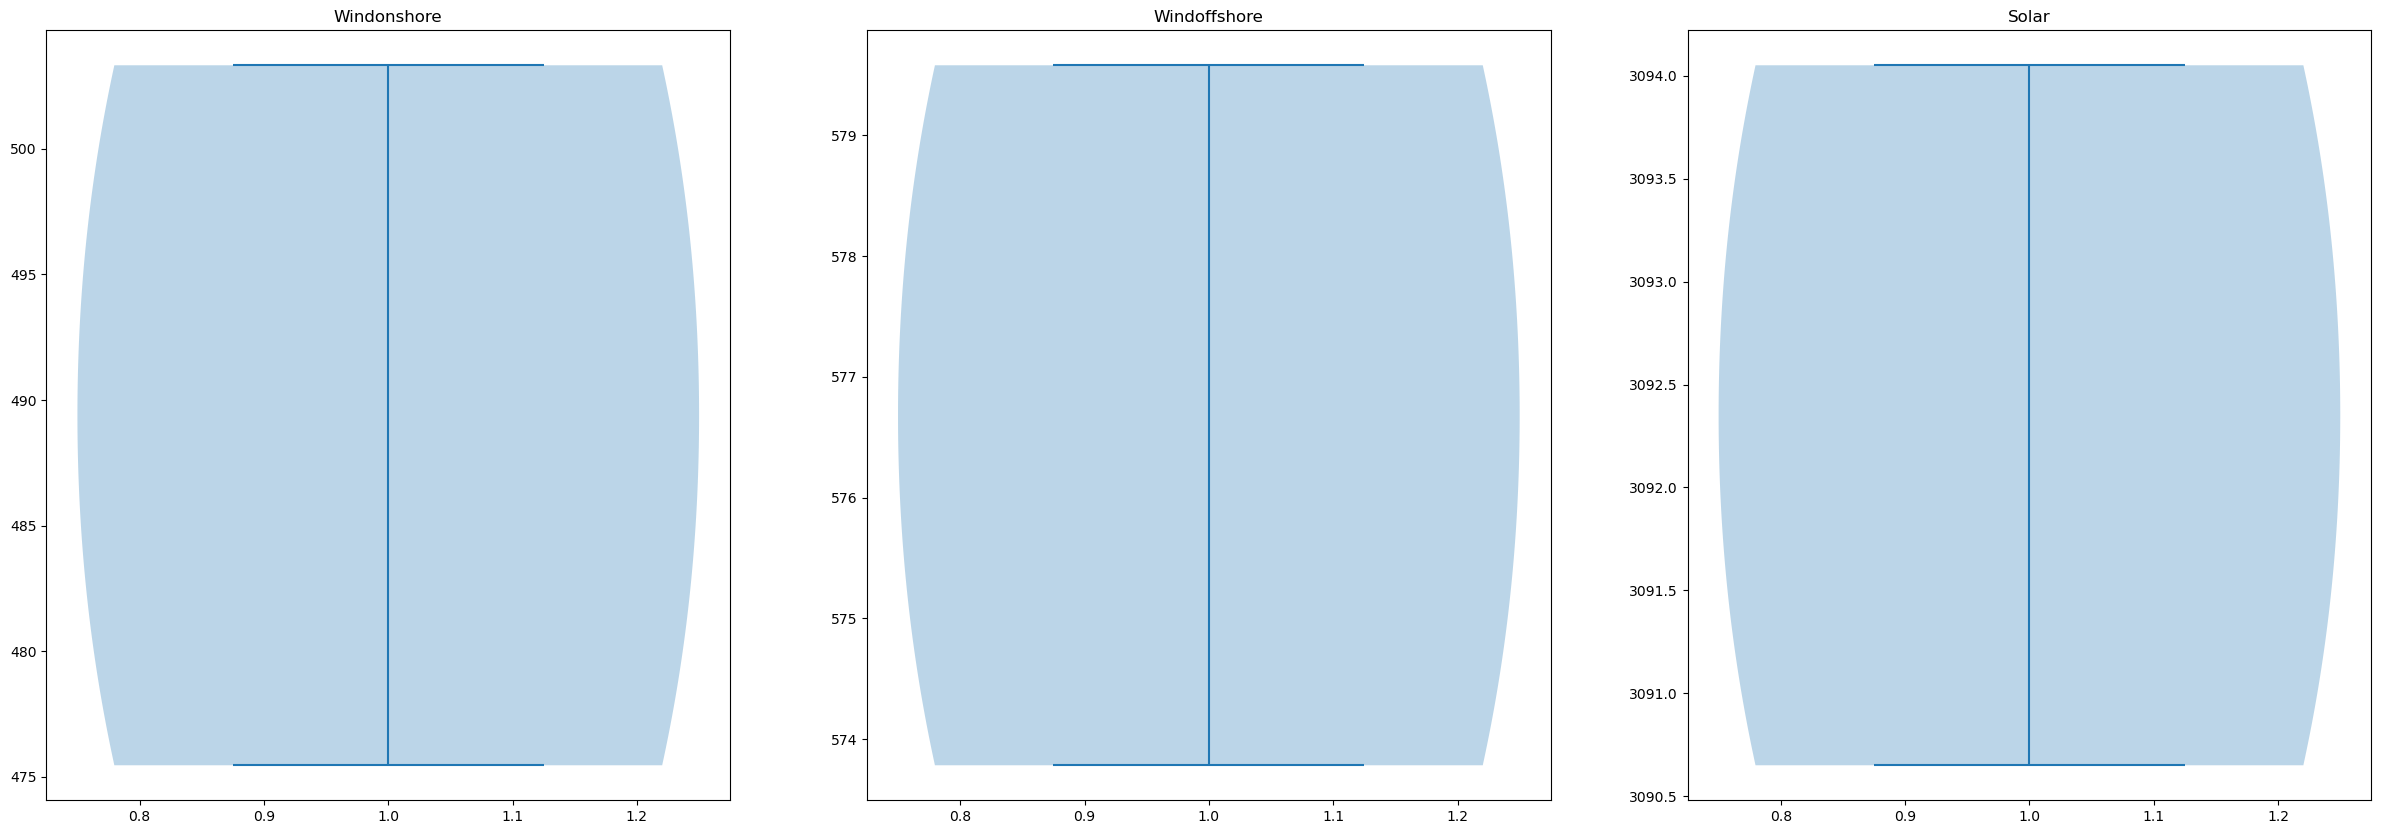

In [114]:


fig, axes = plt.subplots(1,3,figsize=(30,10))
count = 0

for technology in technologies:
    #(
    #    p_cap2
    #    .loc[(' baseline',slice(None),slice(None),'level')]
    #    .groupby('technology').sum()
    #    .reset_index()
    #    .query("technology == @technology")
    #    .plot.scatter(ax=axes[count],x = 'technology',y='installed_capacity_GW',s=100,color='grey')
    #)

    axes[count].violinplot(dataset = (
        p_cap2
        .query("type == 'level'")
        .reset_index()
        .groupby(['scenario','technology']).sum()
        .reset_index()
        .assign(slack_level = lambda x : x.scenario.str.split("_").str[3])
        .fillna(0)
        .query("technology == @technology")
        .installed_capacity_GW
        .rename(technology))
                   )

    axes[count].set_title(technology)
    count += 1       

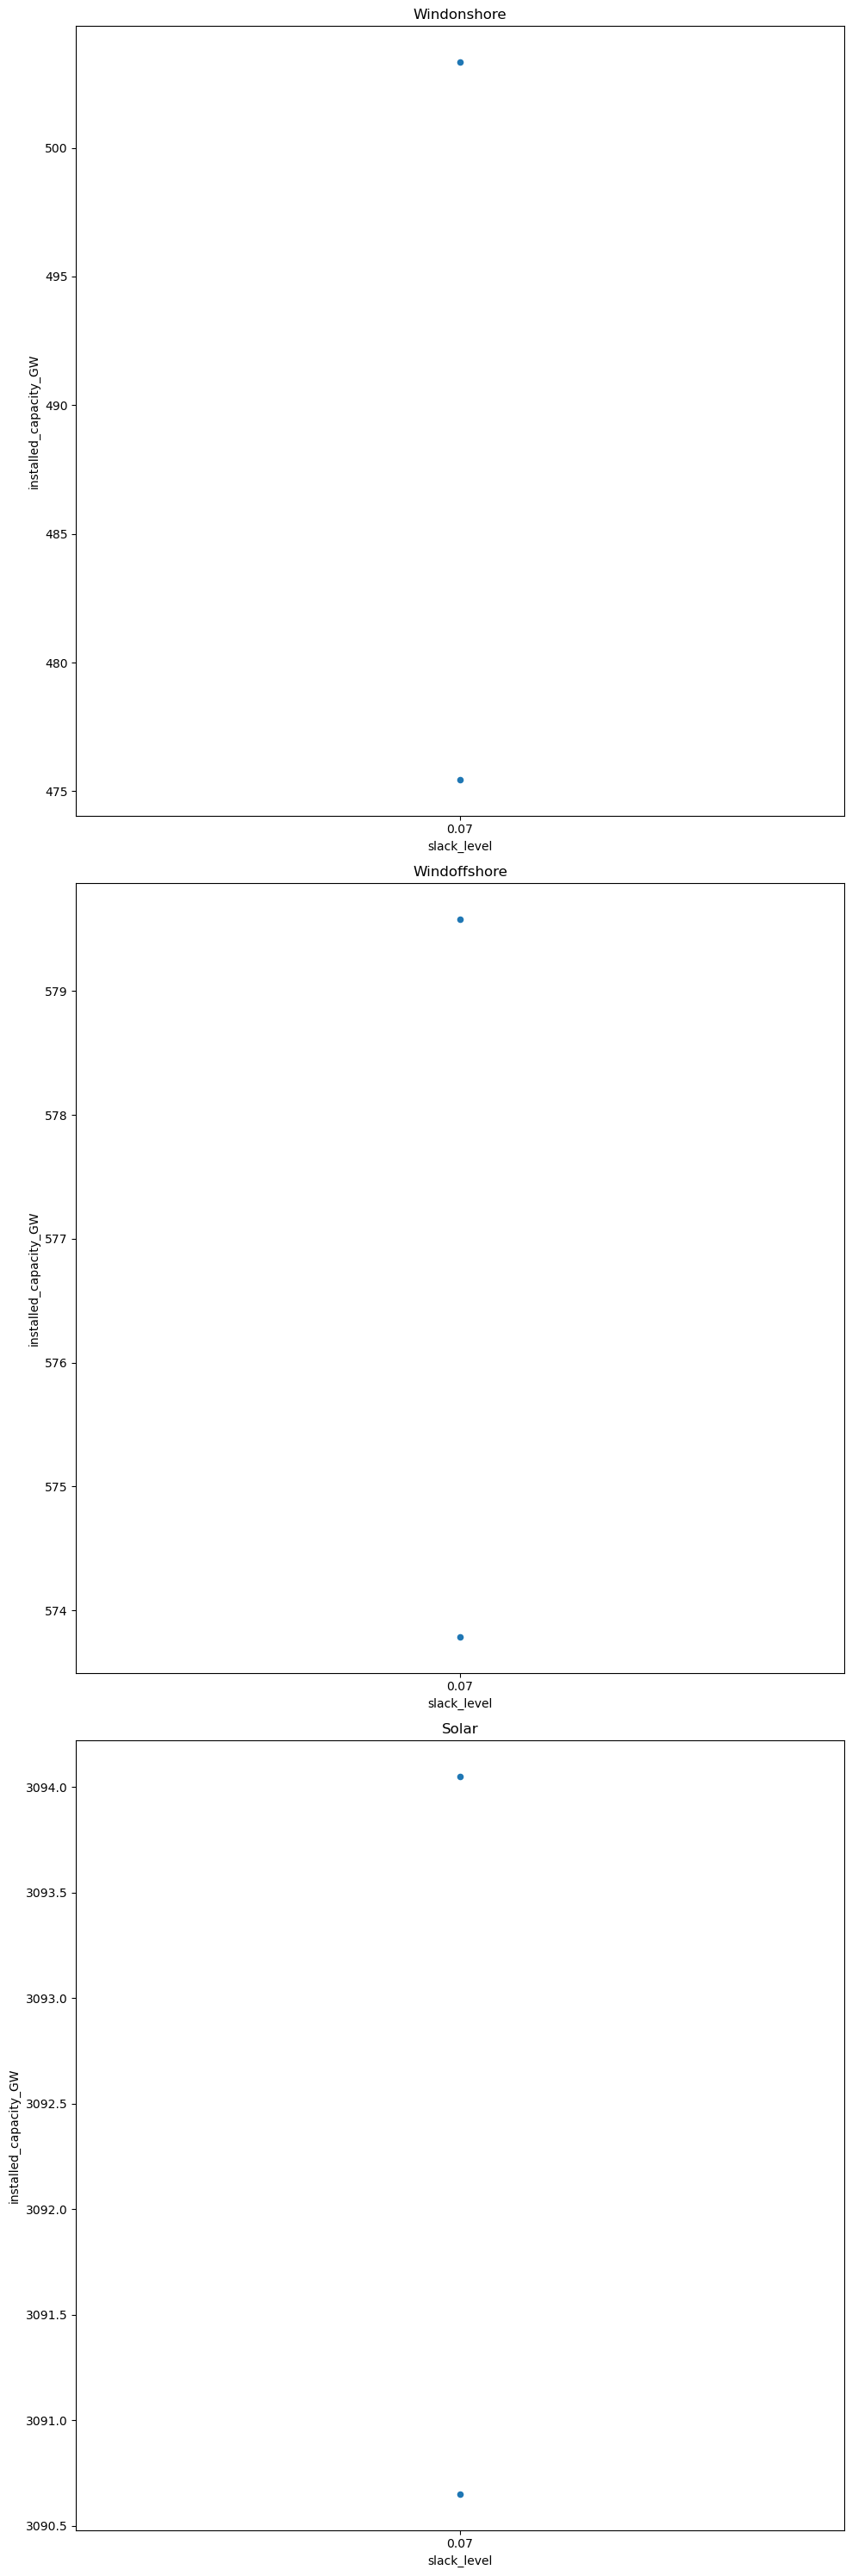

In [116]:
fig, axes = plt.subplots(3,1,figsize=(10,30))
count = 0
for technology in technologies:
    (
        p_cap2
        .query("type == 'level'")
        .reset_index()
        .groupby(['scenario','technology']).sum()
        .reset_index()
        .assign(slack_level = lambda x : x.scenario.str.split("_").str[3])
        .fillna(0)
        .query("technology == @technology")
        .plot.scatter(ax=axes[count],x='slack_level',y='installed_capacity_GW')
    )
    axes[count].set_title(technology)
    count += 1

fig.tight_layout()

In [119]:
df_gini_base.query("principle == 'genperdem' & scenario != 'baseline'")

,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
18,Current system,0.087431,genperdem


In [121]:
df_gini_base.query("principle == 'capperco2' & scenario != 'baseline'")

,scenario,gini_c,principle
8,NO_Solar_maximizing_0.07,0.527236,capperco2
9,SE_Solar_maximizing_0.07,0.523923,capperco2
21,Current system,0.269004,capperco2


In [130]:
df_search_dir = (
    p_cap2
    .query("scenario != 'baseline' & type == 'level'")
    .groupby(['scenario','technology']).sum()
    .reset_index()
    .assign(
        slack = lambda x : x.scenario.str.split('_').str[-1],
        min_max = lambda x : x.scenario.str.split('_').str[-2],
        tech_dir = lambda x : x.scenario.str.split('_').str[-3],
        country_dir = lambda x : x.scenario.str.split('_').str[-4]
    )
    .query("technology == tech_dir")
    .sort_values(by='scenario')
)

df_search_dir


,scenario,technology,installed_capacity_GW,slack,min_max,tech_dir,country_dir
5,NO_Solar_maximizing_0.07,Solar,3094.050296,0.07,maximizing,Solar,NO
13,SE_Solar_maximizing_0.07,Solar,3090.651025,0.07,maximizing,Solar,SE


In [131]:
#gini_color_dict = {'0.05' : 'lightcoral', '0.10' : 'indianred', '0.15' : 'firebrick'}
gini_color_dict = {'0.07' : 'lightcoral', '0.10' : 'indianred', '0.15' : 'firebrick'}

In [134]:
# A way to check whether something will work, otherwise left if not seemed possible
pd.concat([df_search_dir.set_index('scenario'),df_gini.set_index(['scenario','principle'])],axis=1)

,technology,installed_capacity_GW,slack,min_max,tech_dir,country_dir,gini_c
NO_Solar_maximizing_0.07,Solar,3094.050296,0.07,maximizing,Solar,NO,NaN
SE_Solar_maximizing_0.07,Solar,3090.651025,0.07,maximizing,Solar,SE,NaN
"(NO_Solar_maximizing_0.07, genperdem)",NaN,NaN,NaN,NaN,NaN,NaN,0.113319
"(SE_Solar_maximizing_0.07, genperdem)",NaN,NaN,NaN,NaN,NaN,NaN,0.105923
"(NO_Solar_maximizing_0.07, capperpppgdp)",NaN,NaN,NaN,NaN,NaN,NaN,0.457917
"(SE_Solar_maximizing_0.07, capperpppgdp)",NaN,NaN,NaN,NaN,NaN,NaN,0.445834
"(NO_Solar_maximizing_0.07, capperpop)",NaN,NaN,NaN,NaN,NaN,NaN,0.388333
"(SE_Solar_maximizing_0.07, capperpop)",NaN,NaN,NaN,NaN,NaN,NaN,0.384420
"(NO_Solar_maximizing_0.07, capperland)",NaN,NaN,NaN,NaN,NaN,NaN,0.414575
"(SE_Solar_maximizing_0.07, capperland)",NaN,NaN,NaN,NaN,NaN,NaN,0.406060


In [137]:
# Merging two different dataframes based on common index
# here merging based on filtering a specific scenario 
(
    df_gini
    .query("scenario == 'NO_Solar_maximizing_0.07'")        # Any scenario can be filtered here
    .merge(
        p_cap2
        .query("scenario == 'NO_Solar_maximizing_0.07' & type == 'level'")
        .groupby(['scenario','technology']).sum()
        .reset_index()
    )
)

,scenario,gini_c,principle,technology,installed_capacity_GW
0,NO_Solar_maximizing_0.07,0.113319,genperdem,HydroRes,9.400671e+01
1,NO_Solar_maximizing_0.07,0.113319,genperdem,HydroRoR,6.536253e+01
2,NO_Solar_maximizing_0.07,0.113319,genperdem,NaturalgasCCGTwithCCSnewOT,2.260303e+02
3,NO_Solar_maximizing_0.07,0.113319,genperdem,NaturalgasOCGTnew,6.466279e+01
4,NO_Solar_maximizing_0.07,0.113319,genperdem,NuclearEPR,1.628641e-07
5,NO_Solar_maximizing_0.07,0.113319,genperdem,Solar,3.094050e+03
6,NO_Solar_maximizing_0.07,0.113319,genperdem,Windoffshore,5.795798e+02
7,NO_Solar_maximizing_0.07,0.113319,genperdem,Windonshore,4.754537e+02
8,NO_Solar_maximizing_0.07,0.457917,capperpppgdp,HydroRes,9.400671e+01
9,NO_Solar_maximizing_0.07,0.457917,capperpppgdp,HydroRoR,6.536253e+01


In [142]:
principle = 'genperdem'

technology = 'Solar'


(
    df_gini
    .query("scenario == 'NO_Solar_maximizing_0.07'")        # Any scenario can be filtered here
    .merge(
        p_cap2
        .query("scenario == 'NO_Solar_maximizing_0.07' & type == 'level'")
        .groupby(['scenario','technology']).sum()
        .reset_index()
        #.query('technology == @technology')
    ).query('technology == @technology')
    .query("principle == @principle")
)


,scenario,gini_c,principle,technology,installed_capacity_GW
5,NO_Solar_maximizing_0.07,0.113319,genperdem,Solar,3094.050296


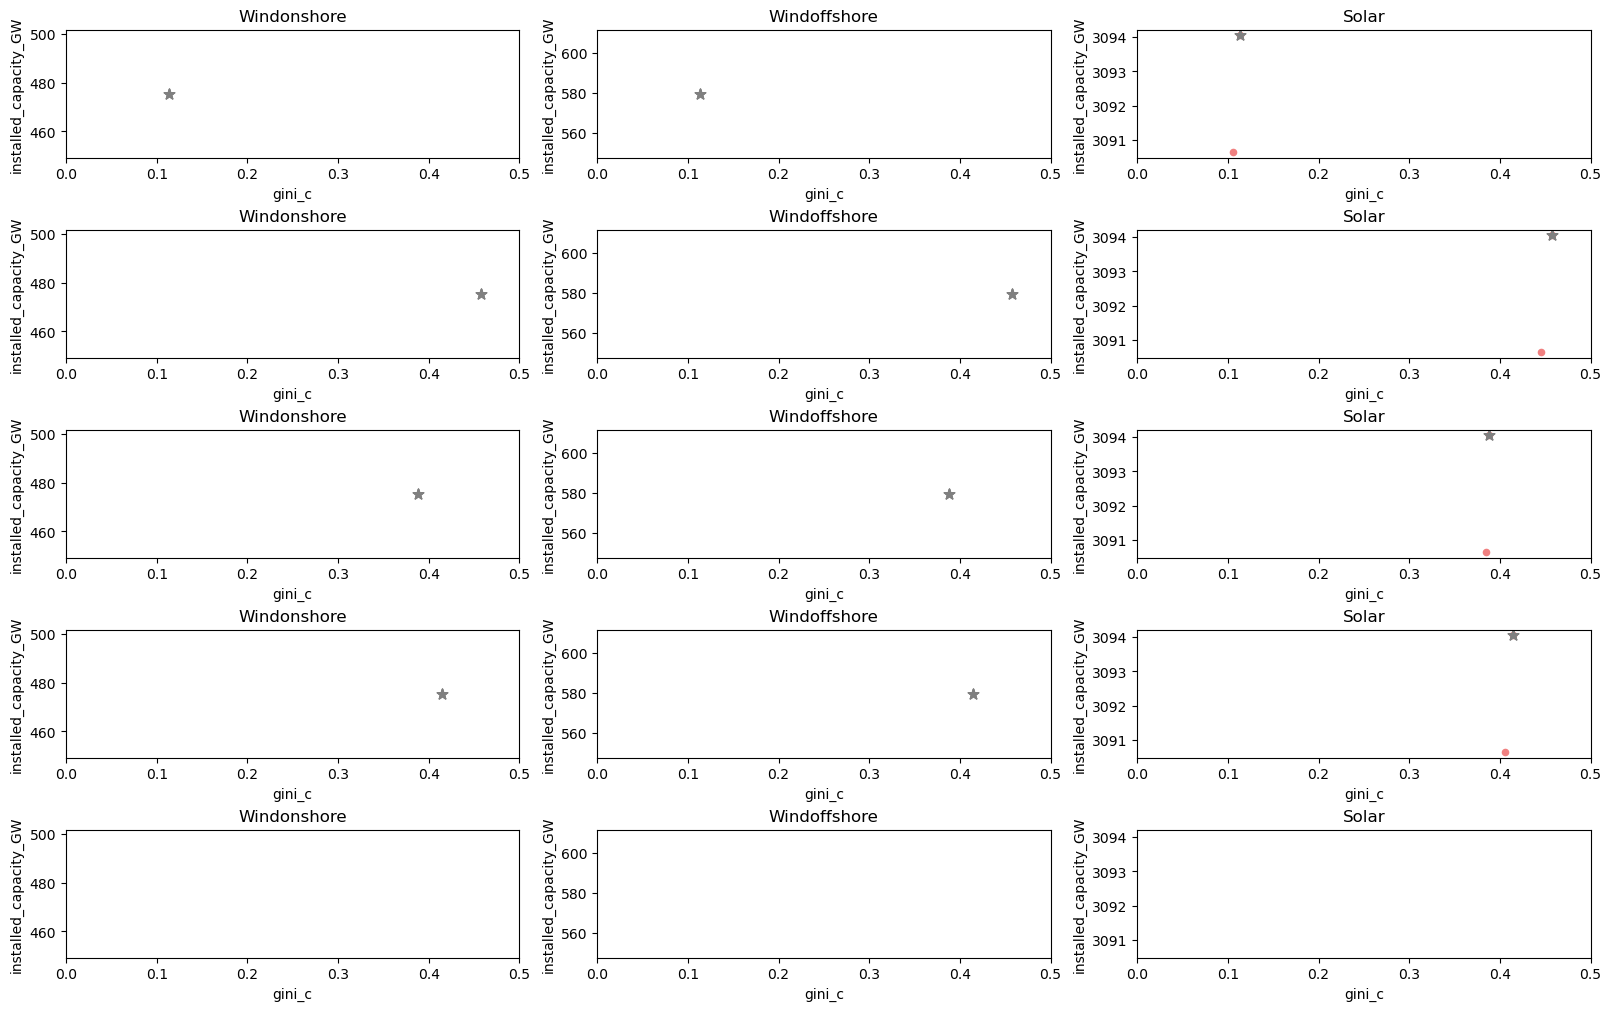

In [158]:
color_list = ['green','blue','red']

fig, axes = plt.subplots(5,3,figsize=(16,10),layout='constrained')
count = 0
row = 0
column = 0

for principle in principle_list_short:
    for technology in technologies:
        for gini in gini_color_dict.keys():
            (
                df_search_dir
                .merge(df_gini.query("principle == @principle & scenario != 'baseline'"))  # merging two data frames to plot one dataframes value @x-axis while other y-axis
                .query("technology == @technology & slack == @gini")
                .plot.scatter(ax=axes[row,column],x='gini_c',y = 'installed_capacity_GW',c=gini_color_dict[gini])
            )

            (
                df_gini
                .query("scenario == 'NO_Solar_maximizing_0.07'")
                .merge(
                    p_cap2
                    .query("scenario == 'NO_Solar_maximizing_0.07' & type == 'level'")
                    .groupby(['scenario','technology']).sum()
                    .reset_index()
                    .query("technology == @technology"))
                .query("principle == @principle")
                .plot.scatter(ax=axes[row,column], x = 'gini_c', y = 'installed_capacity_GW', c = 'grey',marker = '*',s = 60)
            )


        axes[row,column].set_title(technology)
        axes[row,column].set_xlim((0,0.5))
        if column != 2:
            column += 1 
        else:
            column = 0
            row += 1


In [159]:
df_wide2

,scenario,technology,installed_capacity_GW
0,NO_Solar_maximizing_0.07,HydroRes,9.400671e+01
1,NO_Solar_maximizing_0.07,HydroRoR,6.536253e+01
2,NO_Solar_maximizing_0.07,NaturalgasCCGTwithCCSnewOT,2.260303e+02
3,NO_Solar_maximizing_0.07,NaturalgasOCGTnew,6.466279e+01
4,NO_Solar_maximizing_0.07,NuclearEPR,1.628641e-07
5,NO_Solar_maximizing_0.07,Solar,3.094050e+03
6,NO_Solar_maximizing_0.07,Windoffshore,5.795798e+02
7,NO_Solar_maximizing_0.07,Windonshore,4.754537e+02
8,SE_Solar_maximizing_0.07,HydroRes,9.400671e+01
9,SE_Solar_maximizing_0.07,HydroRoR,6.536253e+01


C:\Users\javedm\AppData\Local\Temp\ipykernel_10952\1904328794.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set(xticklabels=['Onshore','Offshore'])


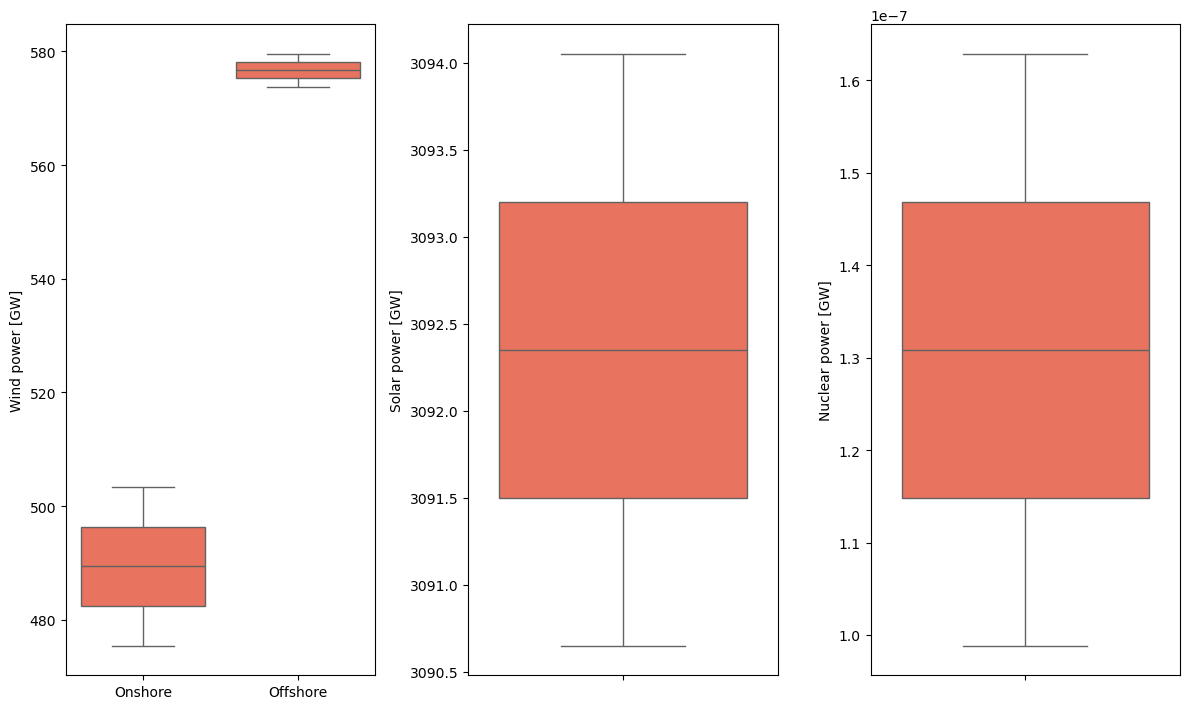

In [169]:
fig, axes = plt.subplots(1, 3, figsize=(12, 7.2))
fig.subplots_adjust(left=0, right=1)

sns.boxplot(
        ax=axes[0],
        x='technology', 
        y='installed_capacity_GW', 
        data=df_wide2.set_index('technology').loc[['Windonshore','Windoffshore']].reset_index(), 
        showfliers=True, 
        color='tomato', 
        #hue='scenario',
        #labels = None,
)

sns.boxplot(
        ax=axes[1],
        x='technology', 
        y='installed_capacity_GW', 
        data=df_wide2[df_wide2['technology'] == 'Solar'], 
        showfliers=True, 
        color='tomato', 
        #hue='scenario',
        #labels = None,
)


sns.boxplot(
        ax=axes[2],
        x='technology', 
        y='installed_capacity_GW', 
        data=df_wide2[df_wide2['technology'] == 'NuclearEPR'], 
        showfliers=True, 
        color='tomato', 
        #hue='scenario',
        #labels = None,
)

axes[0].set_ylabel('Wind power [GW]')
axes[0].set_xlabel(None)
axes[0].set(xticklabels=['Onshore','Offshore'])

#axes[1].set_ylabel('Offshore wind power [GW]')
#axes[1].set_xlabel(None)
#axes[1].set(xticklabels=[])

axes[1].set_ylabel('Solar power [GW]')
axes[1].set_xlabel(None)
axes[1].set(xticklabels=[])

axes[2].set_ylabel('Nuclear power [GW]')
axes[2].set_xlabel(None)
axes[2].set(xticklabels=[])

fig.tight_layout()

#plt.savefig('boxplots_MENOFS_technologies.png',bbox_inches='tight')
#plt.savefig('boxplots_MENOFS_technologies.pdf',bbox_inches='tight')

C:\Users\javedm\AppData\Local\Temp\ipykernel_10952\3481156313.py:101: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


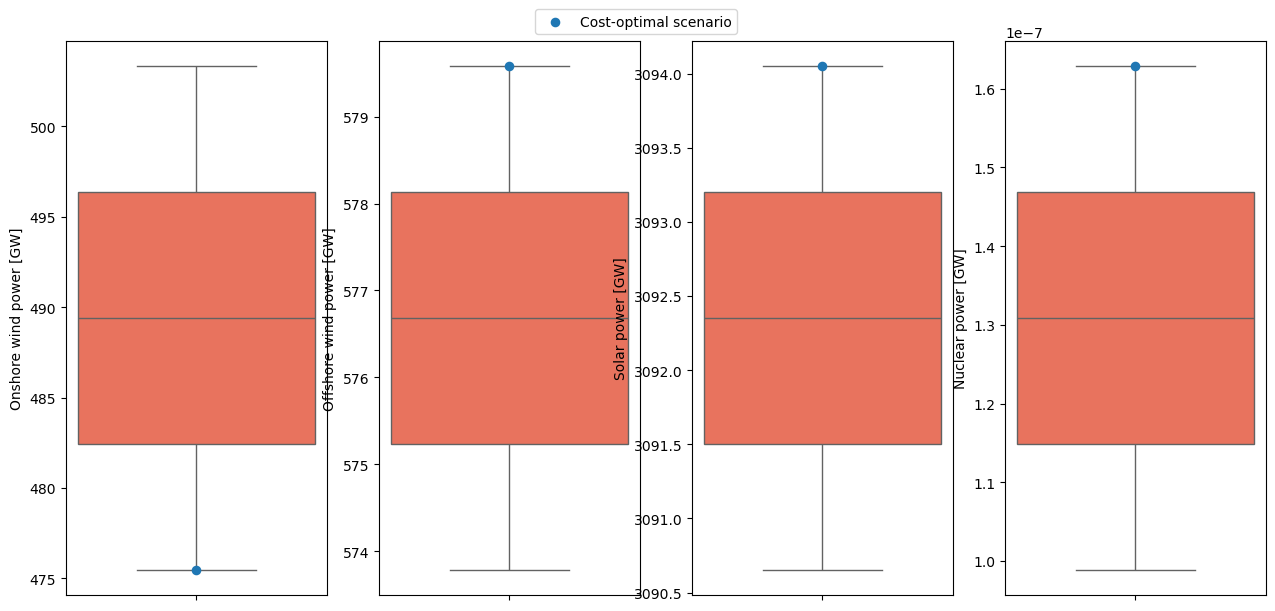

In [194]:
fig, axes = plt.subplots(1, 4, figsize=(12, 7.2))
fig.subplots_adjust(left=0, right=1)

sns.boxplot(
        ax=axes[0],
        x='technology', 
        y='installed_capacity_GW', 
        data=df_wide2[df_wide2['technology'] == 'Windonshore'], 
        showfliers=True, 
        color='tomato', 
        #hue='scenario',
        #labels = None,
) 
p_cap2.loc[('NO_Solar_maximizing_0.07',slice(None), slice(None), 'level')].groupby('technology').sum().loc['Windonshore'].to_frame().T.reset_index().plot.scatter(
    x='index',
    y = 'installed_capacity_GW', 
    ax=axes[0],
    zorder=10, 
    s = 35,
    label = 'Cost-optimal scenario'
)
axes[0].legend([],loc='upper right',frameon=False)

sns.boxplot(
        ax=axes[1],
        x='technology', 
        y='installed_capacity_GW', 
        data=df_wide2[df_wide2['technology'] == 'Windoffshore'], 
        showfliers=True, 
        color='tomato', 
        #hue='scenario',
        #labels = None,
) 
p_cap2.loc[('NO_Solar_maximizing_0.07',slice(None), slice(None), 'level')].groupby('technology').sum().loc['Windoffshore'].to_frame().T.reset_index().plot.scatter(
    x='index',
    y = 'installed_capacity_GW', 
    ax=axes[1],
    zorder=10, 
    s = 35,
    label = 'Cost-optimal scenario'
)
axes[1].legend([],loc='upper right',frameon=False)

sns.boxplot(
        ax=axes[2],
        x='technology', 
        y='installed_capacity_GW', 
        data=df_wide2[df_wide2['technology'] == 'Solar'], 
        showfliers=True, 
        color='tomato', 
        #hue='scenario',
        #labels = None,
)
p_cap2.loc[('NO_Solar_maximizing_0.07',slice(None), slice(None), 'level')].groupby('technology').sum().loc['Solar'].to_frame().T.reset_index().plot.scatter(
    x='index',
    y = 'installed_capacity_GW', 
    ax=axes[2],
    zorder=10, 
    s = 35,
    label = 'Cost-optimal scenario'
)
axes[2].legend([],loc='upper right',frameon=False)

sns.boxplot(
        ax=axes[3],
        x='technology', 
        y='installed_capacity_GW', 
        data=df_wide2[df_wide2['technology'] == 'NuclearEPR'], 
        showfliers=True, 
        color='tomato', 
        #hue='scenario',
        #labels = None,
)
p_cap2.loc[('NO_Solar_maximizing_0.07',slice(None), slice(None), 'level')].groupby('technology').sum().loc['NuclearEPR'].to_frame().T.reset_index().plot.scatter(
    x='index',
    y = 'installed_capacity_GW', 
    ax=axes[3],
    zorder=10, 
    s = 35,
    label = 'Cost-optimal scenario'
)
axes[3].legend(loc='upper right',frameon=True,bbox_to_anchor=[-1,1.07])

axes[0].set_ylabel('Onshore wind power [GW]')
axes[0].set_xlabel(None)
axes[0].set(xticklabels=[])

axes[1].set_ylabel('Offshore wind power [GW]')
axes[1].set_xlabel(None)
axes[1].set(xticklabels=[])

axes[2].set_ylabel('Solar power [GW]')
axes[2].set_xlabel(None)
axes[2].set(xticklabels=[])

axes[3].set_ylabel('Nuclear power [GW]')
axes[3].set_xlabel(None)
axes[3].set(xticklabels=[])


fig.tight_layout()

#plt.savefig('figures/boxplots_MENOFS_technologies.png',bbox_inches='tight')
#plt.savefig('figures/boxplots_MENOFS_technologies.pdf',bbox_inches='tight')


In [188]:
df_wide2[df_wide2['technology'] == 'Windoffshore']

,scenario,technology,installed_capacity_GW
6,NO_Solar_maximizing_0.07,Windoffshore,579.579780
14,SE_Solar_maximizing_0.07,Windoffshore,573.784813


# Also has done mean/max calculations. Leaving for now

In [195]:
df_gen

electricity_generatioN_GWh
scenario                 zone technology  hour type                             
NO_Solar_maximizing_0.07 AT   HydroRes    0    level                7.257657e-09
                                          1    level                7.257638e-09
                                          2    level                7.257672e-09
                                          3    level                7.257705e-09
                                          4    level                7.257710e-09
...                                                                          ...
SE_Solar_maximizing_0.07 UK   Windonshore 8755 level                4.138963e+00
                                          8756 level                4.336057e+00
                                          8757 level                4.336057e+00
                                          8758 level                4.533150e+00
                                          8759 level                4.533150e+00

[3784320 rows x 1 columns]

In [199]:
principle = 'genperdem'
df_gini_base.set_index(['scenario','principle']).loc[('baseline',str(principle))].gini_c

0.138

In [216]:
#Joining several columns of different dataframes into one with respect to similar index 'zone'
df_lorenz = df_gen.loc[('NO_Solar_maximizing_0.07',slice(None),slice(None),slice(None),'level')
].groupby(
    'zone'
).sum(
).join(
    dem.loc[(('NO_Solar_maximizing_0.07'),slice(None))].drop(columns= {'hour'})
).join(
    df_pop.drop(columns={'source'})
).join(
    df_econ.drop(columns={'gdp_ppp','gdp_nom_cap_USD'})
).join(
    df_land.drop(columns={'source'}).rename({'GB' : 'UK'})
).join(
    p_cap2.loc[('NO_Solar_maximizing_0.07',slice(None),slice(None),'level')].groupby('zone').sum()
)

In [217]:
df_lorenz

,electricity_generatioN_GWh,demand_GWh,population,gdp_nom,gdp_ppp_capita,land_area_2021,installed_capacity_GW
zone,,,,,,,
AT,1.927944e+05,1.274303e+05,8932664,433258,55686,82520,151.839466
BE,9.687082e+04,1.739532e+05,11554767,521861,53089,30280,50.199689
BG,7.332881e+04,7.497775e+04,6916548,69889,24564,108560,61.694410
CH,1.287698e+05,1.261205e+05,8670300,752248,71745,39516,82.398686
CZ,9.229502e+04,1.310577e+05,10701777,245339,41608,77200,83.298628
DE,1.004850e+06,1.034011e+06,83155031,3846413,54844,349380,403.869398
DK,5.891363e+04,6.908834e+04,5840045,356084,60229,40000,49.790192
EE,1.165455e+04,1.691337e+04,1330068,30650,37645,43470,10.358917
ES,5.154384e+05,5.093293e+05,47398695,1281484,37756,499603,383.171414


In [218]:
df_lorenz = df_lorenz.assign(
    share_gen = lambda x : x.electricity_generatioN_GWh/x.electricity_generatioN_GWh.sum(),
    share_dem = lambda x : x.demand_GWh/x.demand_GWh.sum(),
    self_suf = lambda x : x.electricity_generatioN_GWh/x.demand_GWh,
    gen_per_nom_gdp = lambda x : x.electricity_generatioN_GWh/x.gdp_nom,
    gen_per_cap_gdp = lambda x : x.electricity_generatioN_GWh/x.gdp_ppp_capita,
    share_nom_gdp = lambda x : x.gdp_nom/x.gdp_nom.sum(),
    share_cap_gdp = lambda x : x.gdp_ppp_capita/x.gdp_ppp_capita.sum(),
    cap_per_pop = lambda x : x.installed_capacity_GW/x.population,
    share_cap = lambda x : x.installed_capacity_GW/x.installed_capacity_GW.sum(),
    share_pop = lambda x : x.population/x.population.sum(),
    cap_per_area = lambda x : x.installed_capacity_GW/x.land_area_2021,
    share_land = lambda x : x.land_area_2021/x.land_area_2021.sum()
)

In [219]:
df_lorenz

,electricity_generatioN_GWh,demand_GWh,population,gdp_nom,gdp_ppp_capita,land_area_2021,installed_capacity_GW,share_gen,share_dem,self_suf,gen_per_nom_gdp,gen_per_cap_gdp,share_nom_gdp,share_cap_gdp,cap_per_pop,share_cap,share_pop,cap_per_area,share_land
zone,,,,,,,,,,,,,,,,,,,
AT,1.927944e+05,1.274303e+05,8932664,433258,55686,82520,151.839466,0.029249,0.019921,1.512940,0.444987,3.462169,0.022652,0.041464,0.000017,0.033015,0.016952,0.001840,0.017797
BE,9.687082e+04,1.739532e+05,11554767,521861,53089,30280,50.199689,0.014696,0.027194,0.556879,0.185626,1.824687,0.027284,0.039530,0.000004,0.010915,0.021928,0.001658,0.006531
BG,7.332881e+04,7.497775e+04,6916548,69889,24564,108560,61.694410,0.011125,0.011721,0.978008,1.049218,2.985215,0.003654,0.018290,0.000009,0.013414,0.013126,0.000568,0.023414
CH,1.287698e+05,1.261205e+05,8670300,752248,71745,39516,82.398686,0.019536,0.019716,1.021006,0.171180,1.794826,0.039329,0.053421,0.000010,0.017916,0.016454,0.002085,0.008523
CZ,9.229502e+04,1.310577e+05,10701777,245339,41608,77200,83.298628,0.014002,0.020488,0.704232,0.376194,2.218204,0.012827,0.030981,0.000008,0.018112,0.020309,0.001079,0.016650
DE,1.004850e+06,1.034011e+06,83155031,3846413,54844,349380,403.869398,0.152445,0.161645,0.971798,0.261243,18.321967,0.201100,0.040837,0.000005,0.087814,0.157808,0.001156,0.075352
DK,5.891363e+04,6.908834e+04,5840045,356084,60229,40000,49.790192,0.008938,0.010800,0.852729,0.165449,0.978161,0.018617,0.044846,0.000009,0.010826,0.011083,0.001245,0.008627
EE,1.165455e+04,1.691337e+04,1330068,30650,37645,43470,10.358917,0.001768,0.002644,0.689074,0.380246,0.309591,0.001602,0.028030,0.000008,0.002252,0.002524,0.000238,0.009375
ES,5.154384e+05,5.093293e+05,47398695,1281484,37756,499603,383.171414,0.078197,0.079622,1.011994,0.402220,13.651827,0.066999,0.028113,0.000008,0.083314,0.089951,0.000767,0.107752


In [220]:
df_lorenz.sort_values(by='self_suf')

,electricity_generatioN_GWh,demand_GWh,population,gdp_nom,gdp_ppp_capita,land_area_2021,installed_capacity_GW,share_gen,share_dem,self_suf,gen_per_nom_gdp,gen_per_cap_gdp,share_nom_gdp,share_cap_gdp,cap_per_pop,share_cap,share_pop,cap_per_area,share_land
zone,,,,,,,,,,,,,,,,,,,
SI,6.131518e+03,2.758979e+04,2108977,53589,39725,20136,2.562900,0.000930,0.004313,0.222239,0.114417,0.154349,0.002802,0.029579,0.000001,0.000557,0.004002,0.000127,0.004343
LU,4.552684e+03,1.313292e+04,634730,73353,117846,2430,3.584008,0.000691,0.002053,0.346662,0.062065,0.038632,0.003835,0.087748,0.000006,0.000779,0.001205,0.001475,0.000524
BE,9.687082e+04,1.739532e+05,11554767,521861,53089,30280,50.199689,0.014696,0.027194,0.556879,0.185626,1.824687,0.027284,0.039530,0.000004,0.010915,0.021928,0.001658,0.006531
SK,3.852707e+04,5.743619e+04,5459781,105172,31356,48080,30.845412,0.005845,0.008979,0.670780,0.366324,1.228698,0.005499,0.023348,0.000006,0.006707,0.010361,0.000642,0.010370
HU,6.001349e+04,8.740748e+04,9730772,155808,33075,91260,54.053846,0.009105,0.013664,0.686594,0.385176,1.814467,0.008146,0.024628,0.000006,0.011753,0.018467,0.000592,0.019682
EE,1.165455e+04,1.691337e+04,1330068,30650,37645,43470,10.358917,0.001768,0.002644,0.689074,0.380246,0.309591,0.001602,0.028030,0.000008,0.002252,0.002524,0.000238,0.009375
PT,6.880671e+04,9.922652e+04,10298252,228539,34177,91605,49.904248,0.010439,0.015512,0.693431,0.301072,2.013246,0.011949,0.025448,0.000005,0.010851,0.019544,0.000545,0.019757
CZ,9.229502e+04,1.310577e+05,10701777,245339,41608,77200,83.298628,0.014002,0.020488,0.704232,0.376194,2.218204,0.012827,0.030981,0.000008,0.018112,0.020309,0.001079,0.016650
DK,5.891363e+04,6.908834e+04,5840045,356084,60229,40000,49.790192,0.008938,0.010800,0.852729,0.165449,0.978161,0.018617,0.044846,0.000009,0.010826,0.011083,0.001245,0.008627


In [221]:
import numpy as np
from scipy import integrate
from scipy.interpolate import interp1d

<Axes: xlabel='cumulative_gdp'>

<Figure size 1920x1200 with 0 Axes>

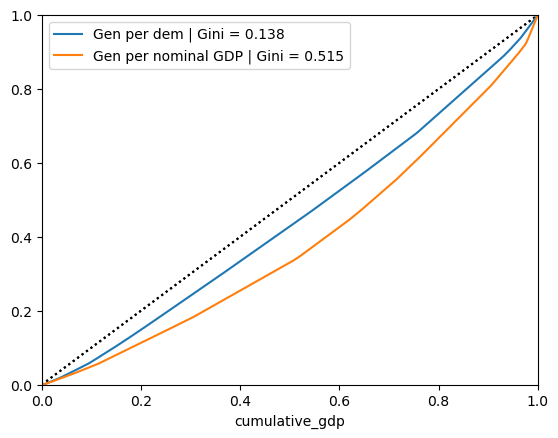

In [249]:
# create the df for the linear plot
df1 = pd.DataFrame({
   'x': [0,1],
   'y': [0,1]
   }
)

plt.figure(figsize=(19.2,12))
ax = df1.plot(
    legend = None,
    linestyle = ':',
    color = 'k'
)

# Gen per demand
principle = 'genperdem'
df_lorenz.sort_values(
    'self_suf',
    ascending=True
).assign(
    cumulative_gen = lambda x: x.share_gen.cumsum(),
    cumulative_dem = lambda x: x.share_dem.cumsum(),
    score = lambda x: x.share_gen * (x.share_dem + 2*(1-x.cumulative_dem))
).plot.line(
    x = 'cumulative_dem',
    y = 'cumulative_gen',
    xlim = [0,1],
    ylim = [0,1],
    ax=ax,
    label = 'Gen per dem |' + ' Gini = ' + str(round(df_gini_base.set_index(['scenario','principle']).loc[('baseline',str(principle))].gini_c, 3))
)

# Gen per nominal GDP
principle = 'capperpppgdp'
df_lorenz.sort_values(
    'gen_per_nom_gdp',
    ascending=True
).assign(
    cumulative_gen = lambda x: x.share_gen.cumsum(),
    cumulative_gdp = lambda x: x.share_nom_gdp.cumsum(),
).plot.line(
    x = 'cumulative_gdp',
    y = 'cumulative_gen',
    xlim = [0,1],
    ylim = [0,1],
    ax=ax,
    #label = 'Gen per nominal GDP |' + ' Gini = ' +  str(round(df_gini.set_index(['scenario','principle']).loc[('baseline',str(principle))].reset_index().gini_c[0],3))    
    label = 'Gen per nominal GDP |' + ' Gini = ' +  str(round(df_gini_base.set_index(['scenario','principle']).loc[('baseline',str(principle))].gini_c,3))
)

# Gen per capita GDP
#principle = 'genpergdp'
#df_lorenz.sort_values(
#    'gen_per_cap_gdp',
#    ascending=True
#).assign(
#    cumulative_gen = lambda x: x.share_gen.cumsum(),
#    cumulative_gdp = lambda x: x.share_cap_gdp.cumsum(),
#).plot.line(
#    x = 'cumulative_gdp',
#    y = 'cumulative_gen',
#    xlim = [0,1],
#    ylim = [0,1],
#    ax=ax,
#    label = 'Gen per capita GDP |' + ' Gini = ' +  str(round(df_gini_base.set_index(['scenario','principle']).loc[('baseline',str(principle))].gini_c,3))
#)


In [242]:
str(round(df_gini_base.set_index(['scenario','principle']).loc[('baseline',str(principle))].gini_c, 3))

'0.138'

In [244]:
df_gini_base

,scenario,gini_c,principle
0,NO_Solar_maximizing_0.07,0.113319,genperdem
1,SE_Solar_maximizing_0.07,0.105923,genperdem
2,NO_Solar_maximizing_0.07,0.457917,capperpppgdp
3,SE_Solar_maximizing_0.07,0.445834,capperpppgdp
4,NO_Solar_maximizing_0.07,0.388333,capperpop
5,SE_Solar_maximizing_0.07,0.384420,capperpop
6,NO_Solar_maximizing_0.07,0.414575,capperland
7,SE_Solar_maximizing_0.07,0.406060,capperland
8,NO_Solar_maximizing_0.07,0.527236,capperco2
9,SE_Solar_maximizing_0.07,0.523923,capperco2


In [251]:
df_gini_stat = pd.DataFrame(columns=['principle','Max','Min','Range','Median','Mean','Skew','Std','Variance','IQR'])

for principle in df_gini.principle.unique():
    quartiles = df_gini.query("principle == @principle").gini_c.quantile([0.25,0.75])
    new_row = pd.DataFrame(
        {
            'principle' : [principle], 
            'Max' : [round(df_gini.query("principle == @principle").gini_c.max(),3)],
            'Min' : [round(df_gini.query("principle == @principle").gini_c.min(),3)],
            'Range' : [round((df_gini.query("principle == @principle").gini_c.max()-df_gini.query("principle == @principle").gini_c.min()),3)],
            'Mean' : [round(df_gini.query("principle == @principle").gini_c.mean(),3)],
            'Median' : [round(df_gini.query("principle == @principle").gini_c.median(),3)],
            'Skew' : [round(df_gini.query("principle == @principle").gini_c.skew(),3)],
            'Std' : [round(df_gini.query("principle == @principle").gini_c.std(),3)],
            'Variance' : [round(df_gini.query("principle == @principle").gini_c.var(),5)],
            'IQR' : [round(quartiles[0.75]-quartiles[0.25],5)]
        },  
    )
    df_gini_stat = pd.concat([df_gini_stat, new_row], ignore_index=True)

In [252]:
df_gini_stat

,principle,Max,Min,Range,Median,Mean,Skew,Std,Variance,IQR
0,genperdem,0.113,0.106,0.007,0.110,0.110,NaN,0.005,0.00003,0.00370
1,capperpppgdp,0.458,0.446,0.012,0.452,0.452,NaN,0.009,0.00007,0.00604
2,capperpop,0.388,0.384,0.004,0.386,0.386,NaN,0.003,0.00001,0.00196
3,capperland,0.415,0.406,0.009,0.410,0.410,NaN,0.006,0.00004,0.00426
4,capperco2,0.527,0.524,0.003,0.526,0.526,NaN,0.002,0.00001,0.00166
5,capperold,0.388,0.388,0.000,0.388,0.388,NaN,0.000,0.00000,0.00023


In [253]:
from scipy.spatial import ConvexHull

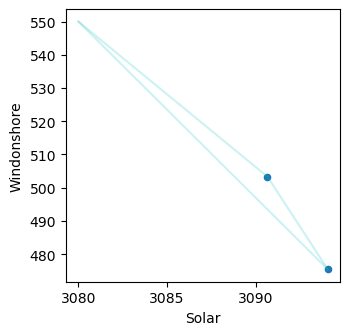

In [273]:
fig, ax = plt.subplots(figsize=(3.54,3.54))

df = p_cap2.loc[
    (slice(None),slice(None),['Solar','Windonshore'],'level')
].groupby(
    ['scenario','technology']
).sum(
).unstack(
).droplevel(
    level=0, axis = 1
)

df.plot.scatter(
    ax=ax,
    x='Solar',
    y='Windonshore'
)

points = df[['Solar','Windonshore']].to_numpy()
new_row = np.array([[3080, 550]])
points = np.append(points, new_row, axis=0)


hull = ConvexHull(points)

#for creating the lines across given data points
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'c',alpha=0.2)

In [279]:
principle = 'capperpppgdp'
one_std = df_gini.query("principle == @principle").gini_c.mean()-df_gini.query("principle == @principle").gini_c.std()
df_gini.query("principle == @principle & gini_c < @one_std").sort_values(by='gini_c').scenario.to_list()

[]

In [265]:
p_cap2.loc[
    (slice(None),slice(None),['Solar','Windonshore'],'level')
].groupby(
    ['scenario','technology']
).sum().unstack().droplevel(level=0, axis=1)

technology,Solar,Windonshore
scenario,,
NO_Solar_maximizing_0.07,3094.050296,475.453707
SE_Solar_maximizing_0.07,3090.651025,503.331280


In [271]:
new_row = np.array([[3080, 550]])
np.append(points, new_row, axis=0)

array([[3094.05029592,  475.4537066 ],
       [3090.65102542,  503.33128039],
       [3080.        ,  550.        ]])

In [277]:
df_gini.query("principle == @principle").gini_c.mean()

0.45187552122528135